# Classification Tests

spiegazione test

### Imports

In [1]:
import re
import xml.etree.ElementTree as ET
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import it_core_news_sm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import collections
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# Skopt functions
from sklearn.metrics import make_scorer, f1_score, recall_score
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import math
import scipy.stats
import sys
from info_gain import info_gain
from copy import copy

In [2]:
#nltk.download('punkt')

## Classes

In [3]:
class CarWordsHandler:
    # https://github.com/n8barr/automotive-model-year-data
    def __init__(self, cars_file):
        self.brands_list = set()
        self.models_list = set()
        f = open(cars_file, "r")
        cars_list = f.read().splitlines()
        for i in range(len(cars_list)):
            brand = cars_list[i].split(',')[0][1:].lower()
            model = cars_list[i].split(',')[1][0:-1].lower()
            self.brands_list.add(brand)
            self.models_list.add(model)
        # remove some useless models
        self.models_list.remove('i')
        #self.models_list.remove('gli')
        #self.models_list.remove('estate')
        self.brands_list = list(self.brands_list)
        self.models_list = list(self.models_list)
        self.brands_list.sort()
        self.models_list.sort()
    
    # binary search to get if a word is a brand 
    def isBrand(self, word):
        word = word.lower()
        first = 0
        last = len(self.brands_list) -1
        while first < last:
            mid = int((last + first) / 2)
            if word == self.brands_list[mid]:
                return True
            elif word < self.brands_list[mid]:
                last = mid
            elif word > self.brands_list[mid]:
                first = mid
            if last-first == 1:
                if self.brands_list[first] == word or self.brands_list[last] == word:
                    return True
                else:
                    return False
    # binary search to get if a word is a brand 
    def isModel(self, word):
        word = word.lower()
        first = 0
        last = len(self.models_list) -1
        while first < last:
            mid = int((last + first) / 2)
            if word == self.models_list[mid]:
                return True
            elif word < self.models_list[mid]:
                last = mid
            elif word > self.models_list[mid]:
                first = mid
            if last-first == 1:
                if self.models_list[first] == word or self.models_list[last] == word:
                    return True
                else:
                    return False

In [4]:
a = CarWordsHandler('resources/cars.txt')
a.models_list
a.isModel('e 110')

False

## Functions

In [5]:
# encoding issues
def correctEncodings(comment):
    fin_comment = comment
    fin_comment = re.sub('Ã¨', 'è', fin_comment)
    fin_comment = re.sub('Ã©', 'é', fin_comment)
    fin_comment = re.sub('Ã¬', 'ì', fin_comment)
    fin_comment = re.sub('Ã²', 'ò', fin_comment)
    fin_comment = re.sub('Ã¹', 'ù', fin_comment)
    fin_comment = re.sub('Ã', 'à', fin_comment)
    return fin_comment
# tokenize function
def tokenize(text):
    tokens = nltk.word_tokenize(text, 'italian')
    italian_stopwords = stopwords.words('italian')
    return [token for token in tokens if not token in italian_stopwords]
# recognize an URL
def isURL(word):
    # http://forum.rusconi.it/gentemotori/viewtopic.php ? t=434&sid=57c88f1b507d8f57717ea18e74e25324Â 
    return len(re.findall("^((http(s){0,1}://)|(www.))\S+$", word)) > 0
# recognize an image tag
def isPicture(word):
    return len(re.findall("^<img.*>$", word)) > 0
# remove punctation
def removePunctation(comment):
    return re.sub(r'\s{2,}', ' ', str(re.sub(r'[\'\"\,\.,\:\-]', ' ', comment)))
# fix issues on urls
def replaceURLs(comment):
    return str(re.sub(r'(http(s){0,1}://|www.)(([^\s]+)|/)+((\s\?\s)[^\s]+){0,1}', 'URL', comment)).replace(u'\xa0', u' ')
# replace images
def replaceIMGs(comment):
    return str(re.sub(r'<img.+>', 'IMG', comment))
# replace brands
def replaceBrands(cwhandler, comment):
    tokens = tokenize(comment)
    for i in range(len(tokens)):
        if cwhandler.isBrand(tokens[i]):
            tokens[i] = 'BRAND'
    return ' '.join(tokens)
# replace models
def replaceModels(cwhandler, comment):
    tokens = tokenize(comment)
    for i in range(len(tokens)):
        if cwhandler.isModel(tokens[i]):
            tokens[i] = 'MODEL'
    return ' '.join(tokens)
# replace question marks
def replaceQMarks(comment):
    comment = re.sub(r'\?{2,}', ' MULTI_QMARK', comment)
    comment = re.sub(r'\?', ' QMARK', comment)
    return comment
# replace esclamation marks
def replaceEMarks(comment):
    comment = re.sub(r'\!{2,}', ' MULTI_EMARK', comment)
    comment = re.sub(r'\!', ' EMARK', comment)
    return comment
# remove character repetitions
def removeRepeat(comment):
    return re.sub(r'(a-zA-Z)\1{2,}', r'\1\1\1', comment)
# replace speed
def replaceSpeed(comment):
    return re.sub(r'([0-9\.*]+(\s*(\-|\/|\s)\s*)+){0,1}[0-9\.*]+(\s*)(km\/h|mph|kmh)', 'SPEED', comment)
# replace consumption
def replaceConsumption(comment):
    return re.sub(r'([0-9\.*]+(\s*(\-|\/|\s)\s*)+){0,1}[0-9\.*]+(\s*)(km\/l|mpg)', 'CONSUMPTION', comment)
# replace weight
def replaceWeight(comment):
    return re.sub(r'[0-9\.*]+(\s*)(kg|tonnellate|ton|chili|kili)', 'WEIGHT', comment)
# replace power + torque
def replacePower(comment):
    return re.sub(r'[0-9]+\s*(cv|nm|kw)', 'POWER', comment)
# replace distance
def replaceDistance(comment):
    return re.sub(r'([0-9\.*]+(\s*(\-|\/|\s)\s*)+){0,1}[0-9\.*]+(\s*)(km|miles|kilometri|chilometri)', 'DISTANCE', comment)
# replace numbers
def replaceNumbers(comment):
    return re.sub(r'[0-9]{3,}', 'NUMBER', comment)


Sentiment http://valeriobasile.github.io/twita/sentix.html

In [6]:
class ItalianWordsHandler:
    # https://dspace-clarin-it.ilc.cnr.it/repository/xmlui/handle/20.500.11752/ILC-73
    def __init__(self, words_file):
        # words information
        self.words_dict = dict()
        root = ET.parse(words_file).getroot()
        for entry in root.findall('Lexicon/LexicalEntry'):
            word = entry.find('Lemma').get('writtenForm')
            pos = entry.get('partOfSpeech')
            senti = entry.find('Sense/Sentiment').get('polarity')
            conf = entry.find('Sense/Confidence').get('score')
            self.words_dict[word] = {'POS': pos, 'Sentiment': senti, 'Confidence': conf}
        # stemmer
        self.it_stem = nltk.stem.SnowballStemmer("italian", ignore_stopwords=True)
        
    # get word info. None if not exists
    def getWordInfo(self, word):
        # fields: POS, Sentiment, Confidence
        return self.words_dict.get(word)
    
    # italian stemmer http://snowball.tartarus.org/algorithms/italian/stemmer.html
    def stem(self, comment):
        tokens = tokenize(comment)
        return ' '.join([token if token.isupper() else self.it_stem.stem(token) for token in tokens])
    
    # correct words
    def correctWords(self, text):
        # not yet implemented
        return text

In [7]:
class Preprocessor:
    
    def __init__(self):
        self.cwh = CarWordsHandler('resources/cars.txt')
        self.iwh = ItalianWordsHandler('resources/ita_opeNER.xml')
        self.pos = it_core_news_sm.load()
    # preprocess text
    # allowed methods: word, swnt, pos
    # ner (named entity recognition), replacing for instance 100 km/h with SPEED
    def preprocessText(self, text, method='word', use_stemmer=False, ner=False):
        if method not in ['word', 'pos', 'swnt']:
            raise ValueError('Method not recognized. Select from word, swnt, pos')
        # correct encodings (not yet implemented)
        fin_text = correctEncodings(text)
        # remove punctation
        fin_text = removePunctation(fin_text)
        # some basic preprocessing
        fin_text = fin_text.lower()
        # correct words (not yet)
        fin_text = self.iwh.correctWords(fin_text)
        # manage repetitions
        fin_text = removeRepeat(fin_text)
        # manage punctation
        fin_text = replaceQMarks(fin_text)
        fin_text = replaceEMarks(fin_text)
        # manage URLs
        fin_text = replaceURLs(fin_text)
        # manage Images
        fin_text = replaceIMGs(fin_text)
        # remove stopwords
        tokens = tokenize(fin_text)
        fin_text = ' '.join(tokens) 
        # NOW DEPENDS ON NER
        if ner:
            # manage brands and models
            fin_text = replaceBrands(self.cwh, fin_text)
            fin_text = replaceModels(self.cwh, fin_text)
            # manage speed consumption and weight
            fin_text = replaceSpeed(fin_text)
            fin_text = replaceConsumption(fin_text)
            fin_text = replaceWeight(fin_text)
            fin_text = replacePower(fin_text)
            fin_text = replaceDistance(fin_text)
            fin_text = replaceNumbers(fin_text)
        # NOW DEPENDS ON METHOD
        if method == 'word':
            # just do nothing except eventually stemming
            if use_stemmer:
                tokens = tokenize(fin_text)
                fin_text = ' '.join([t if t.isupper() else self.iwh.stem(t) for t in tokens]) 
        elif method == 'swnt':
            tokens = tokenize(fin_text)
            swnt_tokens = []
            for t in tokens:
                info = self.iwh.getWordInfo(t)
                if info == None or info['Sentiment'] == None:
                    swnt_tokens.append(t)
                else:
                    # confidence 0-100
                    swnt_tokens.append(str(info['Sentiment'])[:3].upper() + '_' + str(int(float(info['Confidence'])*10)))
            fin_text = ' '.join(swnt_tokens)
            # stemmer
            if use_stemmer:
                tokens = tokenize(fin_text)
                fin_text = ' '.join([t if t.isupper() else self.iwh.stem(t) for t in tokens]) 
        elif method == 'pos':
            doc = self.pos(fin_text)
            pos_tokens = []
            # pos
            for t in doc:
                pos_tokens.append(str(t.pos_))
            # pos_word
            for t in doc:
                pos_tokens.append(str(t.pos_) + '_' + str(t))
                    
            fin_text = ' '.join(pos_tokens)
            # stemmer
            if use_stemmer:
                fin_text = self.iwh.stem(fin_text) 
        
        return str(re.sub(r'\s{2,}', ' ', fin_text))

Preprocessing Example

In [8]:
text = 'Sono reali calcolati nel arco del tutto anno nel estate qualcosa in piÃ¹ causa gomme di 17" e climatizzatore nel inverno un po di meno. Per quanto riguarda le autostrade quelle che percorro io principalmente la A4 e molto congestionata cosi spesso la media e 110-115 km/h che ovviamente influisce positivamente a i consumi. Ma quello che mi piace di piÃ¹ Ã¨ assenza dei guasti. Sulla vecchia Accord il primo guasto lo ho avuto a 200000 km si Ã¨ rotto il termostato della clima. Ogni tanto faccio giro di altri forum e leggo delle turbine rotte catene di distribuzione progettate male iniettori fatti male mah nel 2015 per me sono le cose incomprensibili . Con tutti gli difetti che puÃ² avere preferisco la Honda. '
print(text)
print('##########################################################################################')
p = Preprocessor()
print(p.preprocessText(text, ner=True, use_stemmer=True, method='word'))
print('##########################################################################################')
print(p.preprocessText(text, ner=True, use_stemmer=False, method='swnt'))
print('##########################################################################################')
print(p.preprocessText(text, ner=True, use_stemmer=True, method='pos'))


Sono reali calcolati nel arco del tutto anno nel estate qualcosa in piÃ¹ causa gomme di 17" e climatizzatore nel inverno un po di meno. Per quanto riguarda le autostrade quelle che percorro io principalmente la A4 e molto congestionata cosi spesso la media e 110-115 km/h che ovviamente influisce positivamente a i consumi. Ma quello che mi piace di piÃ¹ Ã¨ assenza dei guasti. Sulla vecchia Accord il primo guasto lo ho avuto a 200000 km si Ã¨ rotto il termostato della clima. Ogni tanto faccio giro di altri forum e leggo delle turbine rotte catene di distribuzione progettate male iniettori fatti male mah nel 2015 per me sono le cose incomprensibili . Con tutti gli difetti che puÃ² avere preferisco la Honda. 
##########################################################################################
real calcol arco anno MODEL qualcos caus gomm MODEL climatizz invern po men riguard autostrad percorr principal MODEL molt congestion cos spess med MODEL SPEED ovvi influ posit consum piac assen

For each comment divide Text from Quote by setting _TEXT or _QUOTE at the end of each word. This after preprocessing

In [9]:
def combine_text_quote(text, quote, divide_quote=True):
    text_tokens = tokenize(text)
    quote_tokens = tokenize(quote)
    combined_tokens = []
    for tt in text_tokens:
        if divide_quote:
            combined_tokens.append(str(tt) + '_TEXT')
        else:
            combined_tokens.append(str(tt))
    for qt in quote_tokens:
        if divide_quote:
            combined_tokens.append(str(qt) + '_QUOTE')
        else:
            combined_tokens.append(str(qt))
    return ' '.join(combined_tokens)

In [10]:
print(combine_text_quote('Bene grazie', 'ciao come va', divide_quote=False))

Bene grazie ciao va


# Dataset

In [30]:
column = 'Assistenza/Concessionari'

In [31]:
original_dataset = pd.read_csv('dataset.csv').fillna('')[['TESTO', '(Testo Citato)', column]]
dataset = original_dataset.copy(deep=True)
dataset

,TESTO,(Testo Citato),Assistenza/Concessionari
0,Allora il problema è che non sono aggiornati i...,,negativo
1,E' virgolettato appositamente.... E soprattutt...,,irrilevante
2,Mah io sulla mappa ev-way ho visto solo tipo 2...,'Inferiore non s ma probabilmente uguale (il m...,irrilevante
3,Ah però.... uno pensa di averne viste tante su...,Sinceramente una differenza di 9.800? non mi p...,irrilevante
4,Basta darsi delle regole e per questo tipo di ...,,irrilevante
5,Personalmente posso ritenermi un possessore di...,,molto positivo
6,Confermo che il posteriore è riuscitissimo e a...,"""sono stato anch'io in conce per altri motivi ...",irrilevante
7,Mi sa che l'unica cosa apprezzabile del rst è ...,,irrilevante
8,grazie ! ! ! ! !,,irrilevante
9,Cosimo hai centrato completamente,,irrilevante


Preprocessing

In [32]:
pp = Preprocessor()
# TESTO
for i in range(len(dataset)):
    dataset['TESTO'][i] = pp.preprocessText(dataset['TESTO'][i], method='word', use_stemmer=True, ner=True)
# (Testo Citato)
for i in range(len(dataset)):
    dataset['(Testo Citato)'][i] = pp.preprocessText(dataset['(Testo Citato)'][i], method='word', use_stemmer=True, ner=True)    

In [33]:
# combine labels "molto positivo" = "positivo" and so on
dataset[column] = dataset[column].replace('molto positivo', 'positivo')
dataset[column] = dataset[column].replace('molto negativo', 'negativo')

Split into training and test

In [34]:
# numpy_dataset = np.array(preprocessed_dataset)
# print('Length: ' + str(numpy_dataset.shape[0]))

In [35]:
np.random.seed(42)
# split 80% training and 20% test
# FARLO RISPETTANDO LA DISTRIBUZIONE
#perm = np.random.permutation(numpy_dataset.shape[0])
#np.random.shuffle(numpy_dataset)
#numpy_dataset = numpy_dataset[perm]
#split = int(0.8 * numpy_dataset.shape[0])
#train_dataset, test_dataset = numpy_dataset[:split,:], numpy_dataset[split:,:]
train_dataset_X, test_dataset_X, train_dataset_y, test_dataset_y = train_test_split(dataset[['TESTO', '(Testo Citato)']], dataset[column], test_size=0.2, stratify=dataset[column], shuffle=True, random_state=52)
# split validation
train_dataset_X, valid_dataset_X, train_dataset_y, valid_dataset_y = train_test_split(train_dataset_X, train_dataset_y, test_size=0.2, stratify=train_dataset_y, shuffle=True, random_state=52)

In [36]:
train_dataset_X

,TESTO,(Testo Citato)
5056,ricord ancor quand manda fot galler perc sap p...,
3780,per divertent dire prosegu sezion alfarome vogl,
253,tuning cos progett accur element concorrent ae...,guard po esemp part cerc maggiorat assett riba...
1683,graz mill esser interven discussion,
3696,teoric version multijet ii,
1985,b benzin aument motissim gen MODEL pres MODEL ...,
288,consegn novembr NUMBER ( ital ) 4r febbrai NUM...,
1526,amic stat molt men artist spacc pietr,prend qualcun attrezz scultor vai MODEL colp v...
2855,prim tagl BRAND ser MODEL turing molt content ...,
5607,infatt dett lasc far vuol comunqu lasc cert li...,effett aut sband nev ciò signif per pilot poss...


Some statistics

In [37]:
collections.Counter(valid_dataset_y)

Counter({'irrilevante': 1063, 'negativo': 40, 'neutro': 29, 'positivo': 17})

In [38]:
train_concat = []
for i in range(len(train_dataset_X)):
    train_concat.append(combine_text_quote(train_dataset_X['TESTO'].iloc[i], train_dataset_X['(Testo Citato)'].iloc[i], divide_quote=False))
valid_concat = []
for i in range(len(valid_dataset_X)):
    valid_concat.append(combine_text_quote(valid_dataset_X['TESTO'].iloc[i], valid_dataset_X['(Testo Citato)'].iloc[i], divide_quote=False))
test_concat = []
for i in range(len(test_dataset_X)):
    test_concat.append(combine_text_quote(test_dataset_X['TESTO'].iloc[i], test_dataset_X['(Testo Citato)'].iloc[i], divide_quote=False))

In [39]:
# access a validation entry
# valid_concat[0]
# valid_dataset_X['TESTO'].loc[2575]

Finally replace text with vector, and replace label with numerical representation

In [40]:
# VECTORIZE
vec = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
#train_dataset_X = vec.fit_transform(train_dataset_X)

# final dataset for the classification
train_X = vec.fit_transform(train_concat)
train_y = np.empty([len(train_concat), 1]).ravel()
valid_X = vec.transform(valid_concat)
valid_y = np.empty([len(valid_concat), 1]).ravel()
# training
train_y = train_dataset_y.replace('irrilevante',  0).replace('positivo', 1).replace('neutro', 1).replace('negativo', 1)
# validation
valid_y = valid_dataset_y.replace('irrilevante',  0).replace('positivo', 1).replace('neutro', 1).replace('negativo', 1)

In [41]:
train_X

<4595x157065 sparse matrix of type '<class 'numpy.float64'>'
	with 349264 stored elements in Compressed Sparse Row format>

In [42]:
collections.Counter(train_y)

Counter({0: 4251, 1: 344})

## SVM _TFIDF Classifier

https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a

First tests for feature selection

In [43]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

# f1, f1_macro (for multiclass), recall
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm_clf, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf.fit(train_X, train_y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.0min finished


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 0.001}
0.000 (+/-0.000) for {'C': 0.01}
0.000 (+/-0.000) for {'C': 0.1}
0.147 (+/-0.097) for {'C': 1.0}
0.281 (+/-0.091) for {'C': 10.0}
0.281 (+/-0.089) for {'C': 100.0}
0.281 (+/-0.089) for {'C': 1000.0}



Refit with best parameters and then draw confusion matrix on validation data

In [44]:
# predictions
pred_y = clf.best_estimator_.predict(valid_X)

F1 score on validation data: 0.43478260869565216
Recall on validation data: 0.3488372093023256
Precision on validation data: 0.5769230769230769


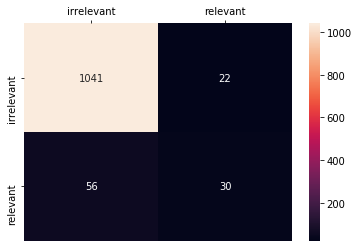

In [45]:
# 0=irrilevante, 1=rilevante
print('F1 score on validation data: ' + str(f1_score(valid_y, pred_y, average='binary')))
print('Recall on validation data: ' + str(recall_score(valid_y, pred_y)))
print('Precision on validation data: ' + str(precision_score(valid_y, pred_y)))
cm = confusion_matrix(valid_y, pred_y, labels=[0, 1])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','relevant'], yticklabels=['irrelevant','relevant'], fmt="d")
ax.xaxis.set_ticks_position('top')

Features selection. Plot by descending weight

The weight/coefficient matrix of a generalised linear model predictor, of shape (n_features,) for binary classification and single-output regression, (n_classes, n_features) for multiclass classification and (n_targets, n_features) for multi-output regression. Note this does not include the intercept (or bias) term, which is stored in intercept_.

When available, feature_importances_ is not usually provided as well, but can be calculated as the norm of each feature’s entry in coef_.

https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights

In [46]:
weights = clf.best_estimator_.coef_
print(weights.shape)
# 6 perchè fa un classifictore per ogni coppia di labels (ovr) -> verificare

(1, 157065)


In [47]:
print(weights.indices)
print(weights.data)

[156431 156310 140401 ...  21374  15034  14817]
[ 0.35294436  0.35294436  0.35294436 ... -0.02852758 -0.00923423
  0.18279416]


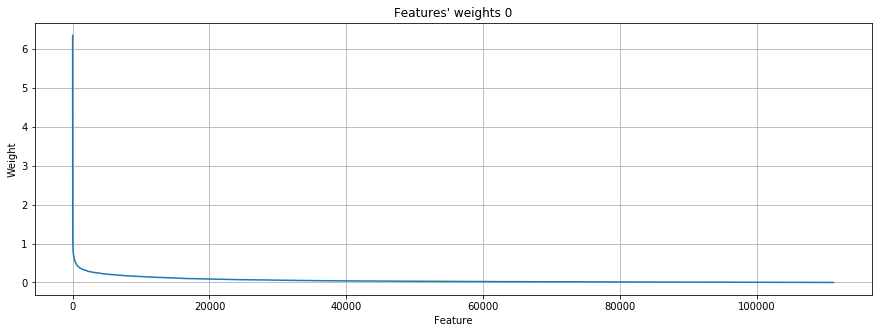

In [48]:
# Data for plotting
for i in range(weights.shape[0]):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(weights[i].data.shape[0]), sorted(abs(weights[i].data), reverse = True))
    ax.set(xlabel='Feature', ylabel='Weight', title='Features\' weights ' + str(i))
    ax.grid()
    #fig.savefig("test.png")
    plt.show()

In [91]:
# select most important features
cutoff_0 = 0.5
selected_features_0 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights[0].data)), weights[0].indices), reverse=True) if i[0] > cutoff_0]

In [92]:
# take the union of selected features (a word important for a classification may be not important for other classifications)
selected_features = set()
for f in selected_features_0:
    selected_features.add(f[1])
print('Selected ' + str(len(selected_features)) + ' features')    

Selected 455 features


Now retry grid search using only selected features

In [93]:
train_X_fs = train_X[:, list(selected_features)]
train_y_fs = train_y
valid_X_fs = valid_X[:, list(selected_features)]
valid_y_fs = valid_y

In [94]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_fs = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_fs = GridSearchCV(svm_clf_fs, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_fs.fit(train_X_fs, train_y_fs)

    print("Best parameters set found on development set:")
    print()
    print(clf_fs.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_fs.cv_results_['mean_test_score']
    stds = clf_fs.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_fs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 100.0}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 0.001}
0.000 (+/-0.000) for {'C': 0.01}
0.000 (+/-0.000) for {'C': 0.1}
0.017 (+/-0.067) for {'C': 1.0}
0.491 (+/-0.096) for {'C': 10.0}
0.597 (+/-0.052) for {'C': 100.0}
0.591 (+/-0.078) for {'C': 1000.0}



[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.8s finished


New confusion matrix

In [95]:
# predictions
pred_y_fs = clf_fs.best_estimator_.predict(valid_X_fs)

F1 score on validation data: 0.4883720930232558
Recall on validation data: 0.4883720930232558
Precision on validation data: 0.4883720930232558


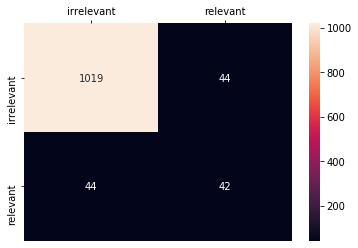

In [96]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 score on validation data: ' + str(f1_score(valid_y_fs, pred_y_fs)))
print('Recall on validation data: ' + str(recall_score(valid_y_fs, pred_y_fs)))
print('Precision on validation data: ' + str(precision_score(valid_y_fs, pred_y_fs)))
cm = confusion_matrix(valid_y_fs, pred_y_fs, labels=[0, 1])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','relevant'], yticklabels=['irrelevant','relevant'], fmt="d")
ax.xaxis.set_ticks_position('top')

Most important features

### 0


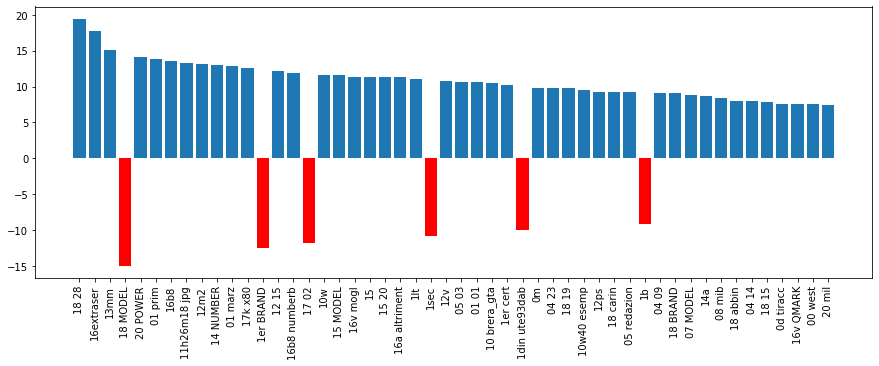

In [97]:
best_n = 50
feature_names = vec.get_feature_names()
for i in range(weights.shape[0]):
    print('### ' + str(i))
    fn = []
    fv = []
    f = [i for i in sorted(zip(map(lambda x: round(x, 4), clf_fs.best_estimator_.coef_[i].data), clf_fs.best_estimator_.coef_[i].indices), reverse=True, key=lambda k: abs(k[0]))][:best_n]
    for j in range(len(f)):
        fn.append(feature_names[f[j][1]])
        fv.append(f[j][0])
        #print(str(feature_names[f[j][1]]) + ': ' + str(f[j][0]))
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar([i for i in range(best_n) if fv[i]>0], [x for x in fv if x>0])
    plt.bar([i for i in range(best_n) if fv[i]<0], [x for x in fv if x<0], color='r')
    plt.xticks(range(best_n), fn, rotation='vertical')
    plt.show()

## Logistic Regression for relevance classification

In [98]:
original_dataset = pd.read_csv('dataset.csv').fillna('')[['TESTO', '(Testo Citato)', column]]
dataset_logreg = original_dataset.copy(deep=True)
dataset_logreg

,TESTO,(Testo Citato),Assistenza/Concessionari
0,Allora il problema è che non sono aggiornati i...,,negativo
1,E' virgolettato appositamente.... E soprattutt...,,irrilevante
2,Mah io sulla mappa ev-way ho visto solo tipo 2...,'Inferiore non s ma probabilmente uguale (il m...,irrilevante
3,Ah però.... uno pensa di averne viste tante su...,Sinceramente una differenza di 9.800? non mi p...,irrilevante
4,Basta darsi delle regole e per questo tipo di ...,,irrilevante
5,Personalmente posso ritenermi un possessore di...,,molto positivo
6,Confermo che il posteriore è riuscitissimo e a...,"""sono stato anch'io in conce per altri motivi ...",irrilevante
7,Mi sa che l'unica cosa apprezzabile del rst è ...,,irrilevante
8,grazie ! ! ! ! !,,irrilevante
9,Cosimo hai centrato completamente,,irrilevante


In [99]:
pp = Preprocessor()
# TESTO
for i in range(len(dataset_logreg)):
    dataset_logreg['TESTO'][i] = pp.preprocessText(dataset_logreg['TESTO'][i], method='word', use_stemmer=True, ner=True)
# (Testo Citato)
for i in range(len(dataset_logreg)):
    dataset_logreg['(Testo Citato)'][i] = pp.preprocessText(dataset_logreg['(Testo Citato)'][i], method='word', use_stemmer=True, ner=True)    

# combine labels "molto positivo" = "positivo" and so on
dataset_logreg[column] = dataset_logreg[column].replace('molto positivo', 'positivo')
dataset_logreg[column] = dataset_logreg[column].replace('molto negativo', 'negativo')

In [100]:
np.random.seed(42)
# split 80% training and 20% test
# FARLO RISPETTANDO LA DISTRIBUZIONE
train_dataset_X_logreg, test_dataset_X_logreg, train_dataset_y_logreg, test_dataset_y_logreg = train_test_split(dataset_logreg[['TESTO', '(Testo Citato)']], dataset_logreg[column], test_size=0.2, stratify=dataset_logreg[column], shuffle=True, random_state=52)
# split validation
train_dataset_X_logreg, valid_dataset_X_logreg, train_dataset_y_logreg, valid_dataset_y_logreg = train_test_split(train_dataset_X_logreg, train_dataset_y_logreg, test_size=0.2, stratify=train_dataset_y_logreg, shuffle=True, random_state=52)

In [101]:
train_dataset_X_logreg

,TESTO,(Testo Citato)
5056,ricord ancor quand manda fot galler perc sap p...,
3780,per divertent dire prosegu sezion alfarome vogl,
253,tuning cos progett accur element concorrent ae...,guard po esemp part cerc maggiorat assett riba...
1683,graz mill esser interven discussion,
3696,teoric version multijet ii,
1985,b benzin aument motissim gen MODEL pres MODEL ...,
288,consegn novembr NUMBER ( ital ) 4r febbrai NUM...,
1526,amic stat molt men artist spacc pietr,prend qualcun attrezz scultor vai MODEL colp v...
2855,prim tagl BRAND ser MODEL turing molt content ...,
5607,infatt dett lasc far vuol comunqu lasc cert li...,effett aut sband nev ciò signif per pilot poss...


In [102]:
collections.Counter(valid_dataset_y_logreg)

Counter({'irrilevante': 1063, 'negativo': 40, 'neutro': 29, 'positivo': 17})

In [103]:
train_concat_logreg = []
for i in range(len(train_dataset_X_logreg)):
    train_concat_logreg.append(combine_text_quote(train_dataset_X_logreg['TESTO'].iloc[i], train_dataset_X_logreg['(Testo Citato)'].iloc[i], divide_quote=False))
valid_concat_logreg = []
for i in range(len(valid_dataset_X_logreg)):
    valid_concat_logreg.append(combine_text_quote(valid_dataset_X_logreg['TESTO'].iloc[i], valid_dataset_X_logreg['(Testo Citato)'].iloc[i], divide_quote=False))
test_concat_logreg = []
for i in range(len(test_dataset_X_logreg)):
    test_concat_logreg.append(combine_text_quote(test_dataset_X_logreg['TESTO'].iloc[i], test_dataset_X_logreg['(Testo Citato)'].iloc[i], divide_quote=False))

In [104]:
# VECTORIZE
vec_logreg = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
#train_dataset_X = vec.fit_transform(train_dataset_X)

# final dataset for the classification
train_X_logreg = vec_logreg.fit_transform(train_concat_logreg)
train_y_logreg = np.empty([len(train_concat_logreg), 1]).ravel()
valid_X_logreg = vec_logreg.transform(valid_concat_logreg)
valid_y_logreg = np.empty([len(valid_concat_logreg), 1]).ravel()
# training
train_y_logreg = train_dataset_y_logreg.replace('irrilevante',  0).replace('positivo', 1).replace('neutro', 1).replace('negativo', 1)
# validation
valid_y_logreg = valid_dataset_y_logreg.replace('irrilevante',  0).replace('positivo', 1).replace('neutro', 1).replace('negativo', 1)

In [105]:
train_X_logreg

<4595x157065 sparse matrix of type '<class 'numpy.float64'>'
	with 349264 stored elements in Compressed Sparse Row format>

First for feature selection

In [106]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)

logreg_clf = LogisticRegression(penalty='l1', random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

# f1, f1_macro (for multiclass), recall
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_logreg = GridSearchCV(logreg_clf, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_logreg.fit(train_X_logreg, train_y_logreg)

    print("Best parameters set found on development set:")
    print()
    print(clf_logreg.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_logreg.cv_results_['mean_test_score']
    stds = clf_logreg.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_logreg.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   18.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 0.001}
0.000 (+/-0.000) for {'C': 0.01}
0.000 (+/-0.000) for {'C': 0.1}
0.317 (+/-0.034) for {'C': 1.0}
0.450 (+/-0.066) for {'C': 10.0}
0.448 (+/-0.049) for {'C': 100.0}
0.440 (+/-0.089) for {'C': 1000.0}



In [107]:
# predictions
pred_y_logreg = clf_logreg.best_estimator_.predict(valid_X_logreg)

F1 score on validation data: 0.5
Recall on validation data: 0.5116279069767442
Precision on validation data: 0.4888888888888889


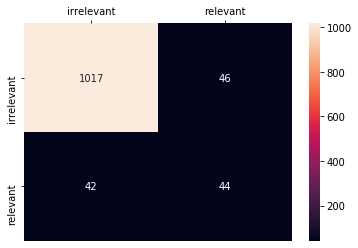

In [108]:
# 0=irrilevante, 1=rilevante
print('F1 score on validation data: ' + str(f1_score(valid_y_logreg, pred_y_logreg, average='binary')))
print('Recall on validation data: ' + str(recall_score(valid_y_logreg, pred_y_logreg)))
print('Precision on validation data: ' + str(precision_score(valid_y_logreg, pred_y_logreg)))
cm = confusion_matrix(valid_y_logreg, pred_y_logreg, labels=[0, 1])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','relevant'], yticklabels=['irrelevant','relevant'], fmt="d")
ax.xaxis.set_ticks_position('top')

In [109]:
weights_logreg = clf_logreg.best_estimator_.coef_
print(weights_logreg.shape)
# 6 perchè fa un classifictore per ogni coppia di labels (ovr) -> verificare

(1, 157065)


In [110]:
weights_logreg.shape

(1, 157065)

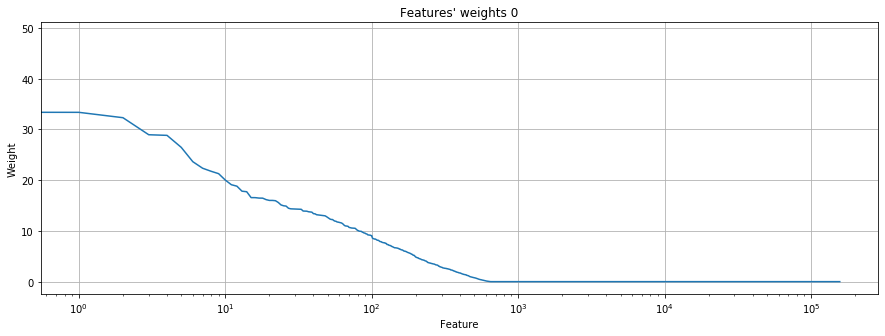

In [111]:
# Data for plotting
for i in range(weights_logreg.shape[0]):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(weights_logreg[i].data.shape[0]), sorted(abs(weights_logreg[i]), reverse = True))
    ax.set(xlabel='Feature', ylabel='Weight', title='Features\' weights ' + str(i))
    ax.set_xscale('log')
    ax.grid()
    #fig.savefig("test.png")
    plt.show()

In [112]:
# take most relevant features
cutoff_0 = 0.1
selected_features_logreg = [i for i in range(len(weights_logreg[0])) if abs(weights_logreg[0][i]) > cutoff_0]
print('Selected ' + str(len(selected_features_logreg)) + ' features')    

Selected 615 features


Refit with selected features

In [113]:
train_X_logreg_fs = train_X_logreg[:, list(selected_features_logreg)]
train_y_logreg_fs = train_y_logreg
valid_X_logreg_fs = valid_X_logreg[:, list(selected_features_logreg)]
valid_y_logreg_fs = valid_y_logreg

In [114]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)

logreg_clf_fs = LogisticRegression(penalty='l2', random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_logreg_fs = GridSearchCV(logreg_clf_fs, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_logreg_fs.fit(train_X_logreg_fs, train_y_logreg_fs)

    print("Best parameters set found on development set:")
    print()
    print(clf_logreg_fs.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_logreg_fs.cv_results_['mean_test_score']
    stds = clf_logreg_fs.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_logreg_fs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters set found on development set:

{'C': 1000.0}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 0.001}
0.000 (+/-0.000) for {'C': 0.01}
0.000 (+/-0.000) for {'C': 0.1}
0.006 (+/-0.023) for {'C': 1.0}
0.374 (+/-0.165) for {'C': 10.0}
0.607 (+/-0.082) for {'C': 100.0}
0.711 (+/-0.031) for {'C': 1000.0}



[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [115]:
# predictions
pred_y_logreg_fs = clf_logreg_fs.best_estimator_.predict(valid_X_logreg_fs)

F1 score on validation data: 0.4731182795698925
Recall on validation data: 0.5116279069767442
Precision on validation data: 0.44


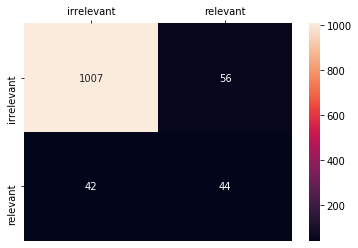

In [116]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 score on validation data: ' + str(f1_score(valid_y_logreg_fs, pred_y_logreg_fs)))
print('Recall on validation data: ' + str(recall_score(valid_y_logreg_fs, pred_y_logreg_fs)))
print('Precision on validation data: ' + str(precision_score(valid_y_logreg_fs, pred_y_logreg_fs)))
cm = confusion_matrix(valid_y_logreg_fs, pred_y_logreg_fs, labels=[0, 1])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','relevant'], yticklabels=['irrelevant','relevant'], fmt="d")
ax.xaxis.set_ticks_position('top')

Most important features

### 0


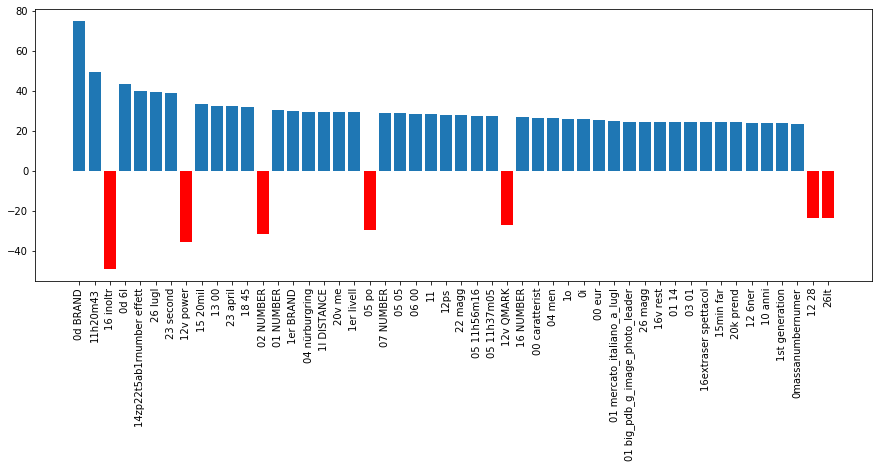

In [117]:
best_n = 50
feature_names = vec.get_feature_names()
for i in range(weights.shape[0]):
    print('### ' + str(i))
    fn = []
    fv = []
    f = [i for i in sorted(zip(map(lambda x: round(x, 4), clf_logreg_fs.best_estimator_.coef_[i]), range(clf_logreg_fs.best_estimator_.coef_[i].shape[0])), reverse=True, key=lambda k: abs(k[0]))][:best_n]
    for j in range(len(f)):
        fn.append(feature_names[f[j][1]])
        fv.append(f[j][0])
        #print(str(feature_names[f[j][1]]) + ': ' + str(f[j][0]))
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar([i for i in range(best_n) if fv[i]>0], [x for x in fv if x>0])
    plt.bar([i for i in range(best_n) if fv[i]<0], [x for x in fv if x<0], color='r')
    plt.xticks(range(best_n), fn, rotation='vertical')
    plt.show()

## Sentiment Classification

In [118]:
# get only rows for sentiment classification
train_dataset_X_snt = train_dataset_X[train_dataset_y != 'irrilevante']
train_dataset_y_snt = train_dataset_y[train_dataset_y != 'irrilevante']
valid_dataset_X_snt = valid_dataset_X[valid_dataset_y != 'irrilevante']
valid_dataset_y_snt = valid_dataset_y[valid_dataset_y != 'irrilevante']
test_dataset_X_snt = test_dataset_X[test_dataset_y != 'irrilevante']
test_dataset_y_snt = test_dataset_y[test_dataset_y != 'irrilevante']

train_concat_snt = []
for i in range(len(train_dataset_X_snt)):
    train_concat_snt.append(combine_text_quote(train_dataset_X_snt['TESTO'].iloc[i], train_dataset_X_snt['(Testo Citato)'].iloc[i], divide_quote=False))
valid_concat_snt = []
for i in range(len(valid_dataset_X_snt)):
    valid_concat_snt.append(combine_text_quote(valid_dataset_X_snt['TESTO'].iloc[i], valid_dataset_X_snt['(Testo Citato)'].iloc[i], divide_quote=False))
test_concat_snt = []
for i in range(len(test_dataset_X_snt)):
    test_concat_snt.append(combine_text_quote(test_dataset_X_snt['TESTO'].iloc[i], test_dataset_X_snt['(Testo Citato)'].iloc[i], divide_quote=False))

In [119]:
collections.Counter(test_dataset_y_snt)

Counter({'negativo': 49, 'neutro': 37, 'positivo': 22})

Vectorize

In [120]:
# VECTORIZE
vec_snt = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
#train_dataset_X = vec.fit_transform(train_dataset_X)

# final dataset for the classification
train_X_snt = vec_snt.fit_transform(train_concat_snt)
valid_X_snt = vec_snt.transform(valid_concat_snt)
# training
train_y_snt = train_dataset_y[train_dataset_y != 'irrilevante'].replace('positivo', 1).replace('neutro', 2).replace('negativo', 3)
# validation
valid_y_snt = valid_dataset_y[valid_dataset_y != 'irrilevante'].replace('positivo', 1).replace('neutro', 2).replace('negativo', 3)

In [121]:
len(train_y_snt)

344

SVM_TFIDF_Classifier without feaure selection

In [122]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_snt = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

# f1, f1_macro (for multiclass), recall
scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_snt = GridSearchCV(svm_clf_snt, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_snt.fit(train_X_snt, train_y_snt)

    print("Best parameters set found on development set:")
    print()
    print(clf_snt.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_snt.cv_results_['mean_test_score']
    stds = clf_snt.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_snt.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.7s remaining:    0.5s


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.209 (+/-0.000) for {'C': 0.001}
0.209 (+/-0.000) for {'C': 0.01}
0.209 (+/-0.000) for {'C': 0.1}
0.290 (+/-0.073) for {'C': 1.0}
0.373 (+/-0.074) for {'C': 10.0}
0.373 (+/-0.074) for {'C': 100.0}
0.373 (+/-0.074) for {'C': 1000.0}



[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [123]:
# predictions
pred_y_snt = clf_snt.best_estimator_.predict(valid_X_snt)

F1 score macro on validation data: 0.46292735042735034
F1 score micro on validation data: 0.5116279069767442


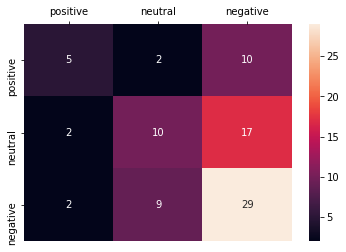

In [124]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 score macro on validation data: ' + str(f1_score(valid_y_snt, pred_y_snt, average='macro')))
print('F1 score micro on validation data: ' + str(f1_score(valid_y_snt, pred_y_snt, average='micro')))
cm_snt = confusion_matrix(valid_y_snt, pred_y_snt, labels=[1, 2, 3])
ax = sns.heatmap(cm_snt, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'])
ax.xaxis.set_ticks_position('top')

Feature Selection

In [125]:
weights_snt = clf_snt.best_estimator_.coef_
print(weights.shape)
# 6 perchè fa un classifictore per ogni coppia di labels (ovr) -> verificare

(1, 157065)


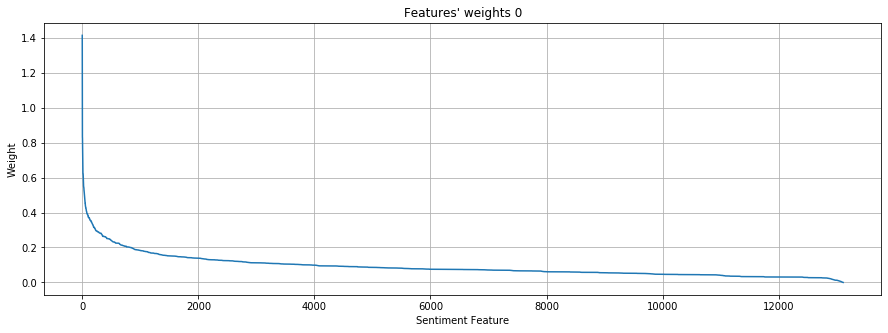

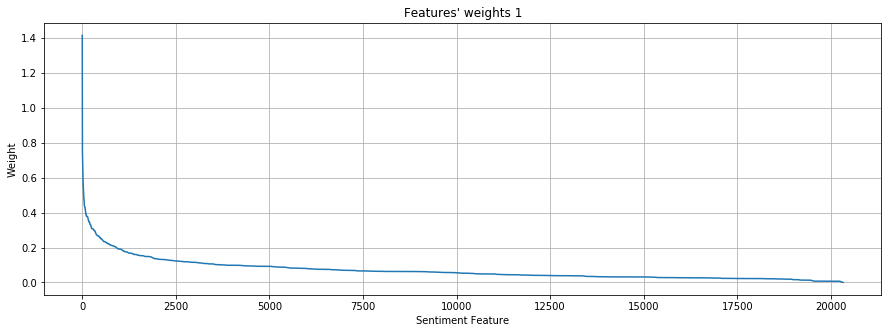

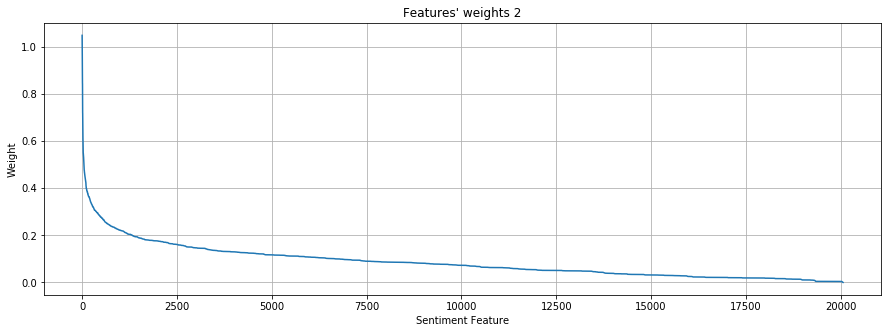

In [126]:
# Data for plotting
for i in range(weights_snt.shape[0]):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(weights_snt[i].data.shape[0]), sorted(abs(weights_snt[i].data), reverse = True))
    ax.set(xlabel='Sentiment Feature', ylabel='Weight', title='Features\' weights ' + str(i))
    ax.grid()
    #fig.savefig("test.png")
    plt.show()

In [211]:
# select most important features
cutoff_0 = 0.05
selected_features_snt_0 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_snt[0].data)), weights_snt[0].indices), reverse=True) if i[0] > cutoff_0]
cutoff_1 = 0.05
selected_features_snt_1 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_snt[1].data)), weights_snt[1].indices), reverse=True) if i[0] > cutoff_1]
cutoff_2 = 0.05
selected_features_snt_2 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_snt[2].data)), weights_snt[2].indices), reverse=True) if i[0] > cutoff_2]

In [212]:
# take the union of selected features (a word important for a classification may be not important for other classifications)
selected_features_snt = set()
for f in selected_features_snt_0:
    selected_features_snt.add(f[1])
for f in selected_features_snt_1:
    selected_features_snt.add(f[1])
for f in selected_features_snt_2:
    selected_features_snt.add(f[1])
print('Selected ' + str(len(selected_features_snt)) + ' features')    

Selected 17886 features


Retry with selected features

In [213]:
train_X_fs_snt = train_X_snt[:, list(selected_features_snt)]
train_y_fs_snt = train_y_snt
valid_X_fs_snt = valid_X_snt[:, list(selected_features_snt)]
valid_y_fs_snt = valid_y_snt

In [214]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_fs_snt = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_fs_snt = GridSearchCV(svm_clf_fs, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_fs_snt.fit(train_X_fs_snt, train_y_fs_snt)

    print("Best parameters set found on development set:")
    print()
    print(clf_fs_snt.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_fs_snt.cv_results_['mean_test_score']
    stds = clf_fs_snt.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_fs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.209 (+/-0.000) for {'C': 0.001}
0.209 (+/-0.000) for {'C': 0.01}
0.209 (+/-0.000) for {'C': 0.1}
0.258 (+/-0.086) for {'C': 1.0}
0.365 (+/-0.100) for {'C': 10.0}
0.365 (+/-0.100) for {'C': 100.0}
0.365 (+/-0.100) for {'C': 1000.0}



In [215]:
# predictions
pred_y_fs_snt = clf_fs_snt.best_estimator_.predict(valid_X_fs_snt)

F1 macro score on validation data: 0.470445116984145
F1 micro score on validation data: 0.5232558139534884


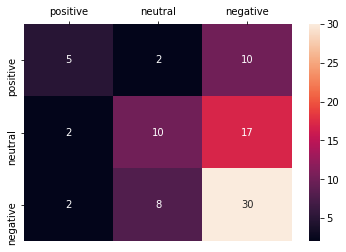

In [216]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_fs_snt, pred_y_fs_snt, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_fs_snt, pred_y_fs_snt, average='micro')))
cm_fs_snt = confusion_matrix(valid_y_fs_snt, pred_y_fs_snt, labels=[1, 2, 3])
ax = sns.heatmap(cm_fs_snt, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'])
ax.xaxis.set_ticks_position('top')

### 0


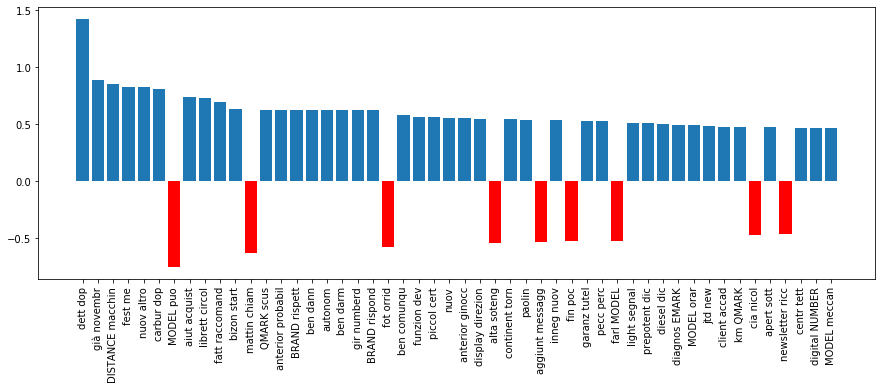

### 1


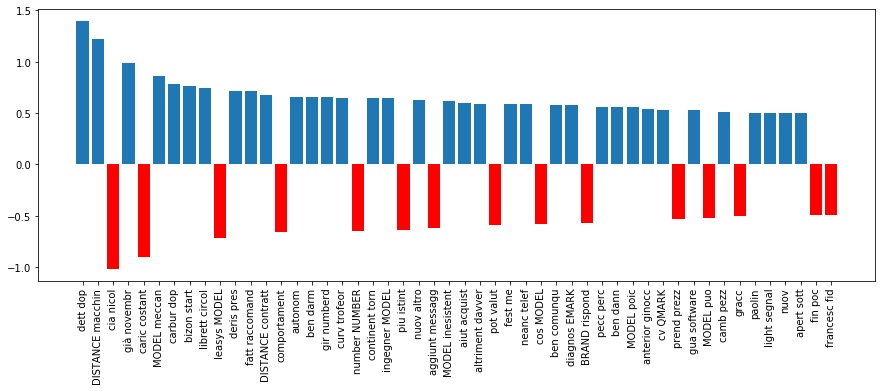

### 2


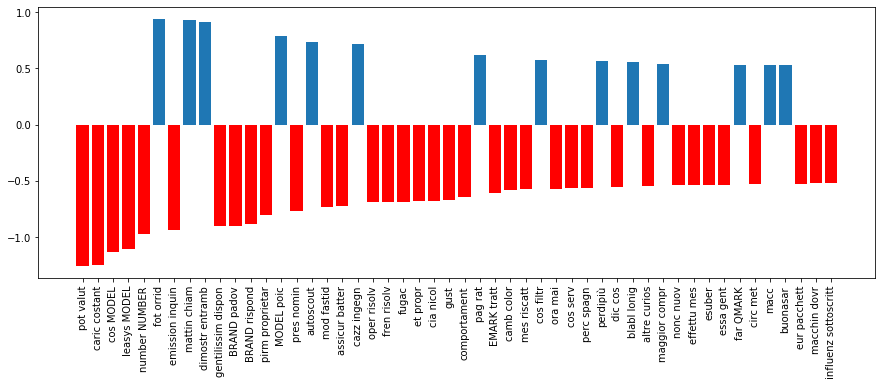

In [217]:
best_n = 50
feature_names_snt = vec_snt.get_feature_names()
for i in range(weights_snt.shape[0]):
    print('### ' + str(i))
    fn_snt = []
    fv_snt = []
    f_snt = [i for i in sorted(zip(map(lambda x: round(x, 4), clf_fs_snt.best_estimator_.coef_[i].data), clf_fs_snt.best_estimator_.coef_[i].indices), reverse=True, key=lambda k: abs(k[0]))][:best_n]
    for j in range(len(f_snt)):
        fn_snt.append(feature_names_snt[f_snt[j][1]])
        fv_snt.append(f_snt[j][0])
        #print(str(feature_names[f[j][1]]) + ': ' + str(f[j][0]))
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar([i for i in range(best_n) if fv_snt[i]>0], [x for x in fv_snt if x>0])
    plt.bar([i for i in range(best_n) if fv_snt[i]<0], [x for x in fv_snt if x<0], color='r')
    plt.xticks(range(best_n), fn_snt, rotation='vertical')
    plt.show()

## Classification with 4 labels

In [218]:
# get only rows for sentiment classification
train_dataset_X_4l = train_dataset_X
train_dataset_y_4l = train_dataset_y
valid_dataset_X_4l = valid_dataset_X
valid_dataset_y_4l = valid_dataset_y
test_dataset_X_4l = test_dataset_X
test_dataset_y_4l = test_dataset_y

train_concat_4l = []
for i in range(len(train_dataset_X_4l)):
    train_concat_4l.append(combine_text_quote(train_dataset_X_4l['TESTO'].iloc[i], train_dataset_X_4l['(Testo Citato)'].iloc[i], divide_quote=False))
valid_concat_4l = []
for i in range(len(valid_dataset_X_4l)):
    valid_concat_4l.append(combine_text_quote(valid_dataset_X_4l['TESTO'].iloc[i], valid_dataset_X_4l['(Testo Citato)'].iloc[i], divide_quote=False))
test_concat_4l = []
for i in range(len(test_dataset_X_4l)):
    test_concat_4l.append(combine_text_quote(test_dataset_X_4l['TESTO'].iloc[i], test_dataset_X_4l['(Testo Citato)'].iloc[i], divide_quote=False))

In [219]:
collections.Counter(test_dataset_y_4l)

Counter({'irrilevante': 1328, 'negativo': 49, 'neutro': 37, 'positivo': 22})

Vectorization

In [220]:
# VECTORIZE
vec_4l = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
#train_dataset_X = vec.fit_transform(train_dataset_X)

# final dataset for the classification
train_X_4l = vec_4l.fit_transform(train_concat_4l)
valid_X_4l = vec_4l.transform(valid_concat_4l)
test_X_4l = vec_4l.transform(test_concat_4l)
# training
train_y_4l = train_dataset_y_4l.replace('irrilevante', 0).replace('positivo', 1).replace('neutro', 2).replace('negativo', 3)
# validation
valid_y_4l = valid_dataset_y_4l.replace('irrilevante', 0).replace('positivo', 1).replace('neutro', 2).replace('negativo', 3)
# test
test_y_4l = test_dataset_y_4l.replace('irrilevante', 0).replace('positivo', 1).replace('neutro', 2).replace('negativo', 3)

In [221]:
len(valid_concat_4l)

1149

SVM _TFIDF Classifier

In [222]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_4l = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

# f1, f1_macro (for multiclass), recall
scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_4l = GridSearchCV(svm_clf_4l, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_4l.fit(train_X_4l, train_y_4l)

    print("Best parameters set found on development set:")
    print()
    print(clf_4l.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_4l.cv_results_['mean_test_score']
    stds = clf_4l.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_4l.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.4min finished


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.240 (+/-0.000) for {'C': 0.001}
0.240 (+/-0.000) for {'C': 0.01}
0.240 (+/-0.000) for {'C': 0.1}
0.260 (+/-0.026) for {'C': 1.0}
0.289 (+/-0.017) for {'C': 10.0}
0.289 (+/-0.017) for {'C': 100.0}
0.289 (+/-0.017) for {'C': 1000.0}



Refit with best parameters and then draw confusion matrix on validation data

In [223]:
# predictions
pred_y_4l = clf_4l.best_estimator_.predict(valid_X_4l)

F1 macro score on validation data: 0.2833444602478883
F1 micro score on validation data: 0.9251523063533508


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


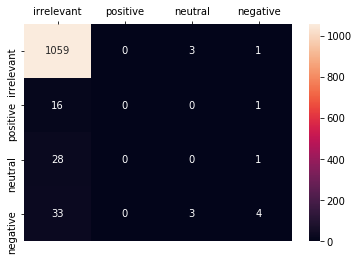

In [224]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_4l, pred_y_4l, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_4l, pred_y_4l, average='micro')))
cm_all = confusion_matrix(valid_y_4l, pred_y_4l, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm_all, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

Features selection. Plot by descending weight


In [225]:
weights_4l = clf_4l.best_estimator_.coef_
print(weights_4l.shape)
# 6 perchè fa un classifictore per ogni coppia di labels (ovr) -> verificare

(6, 157065)


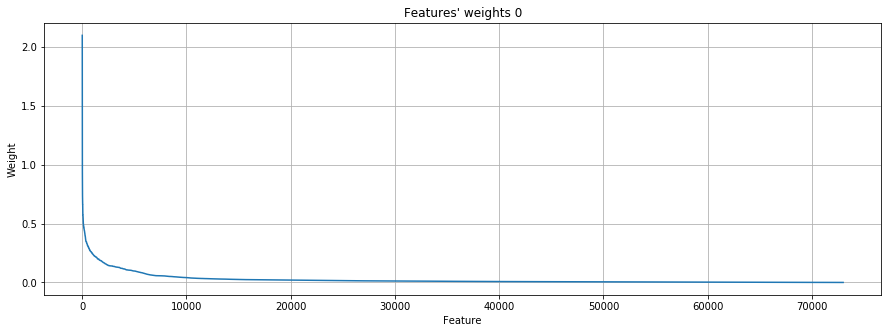

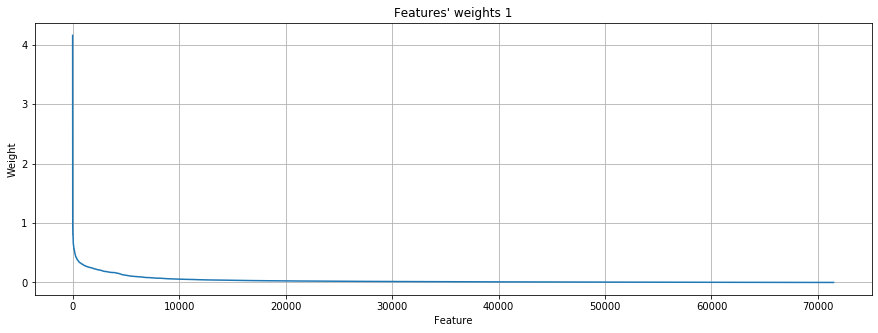

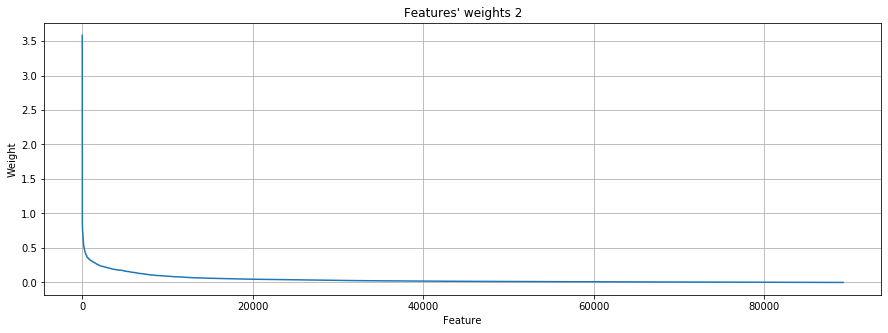

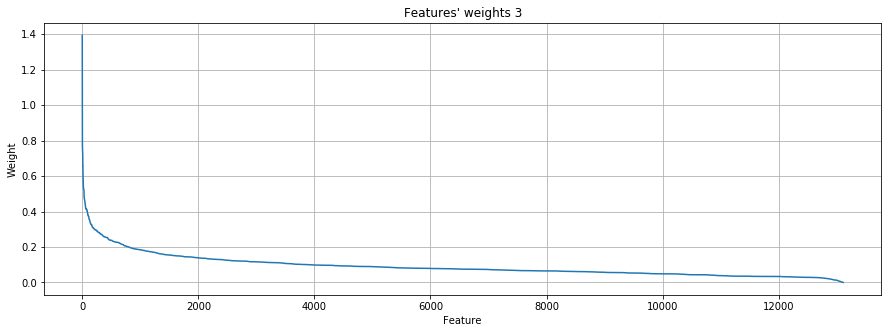

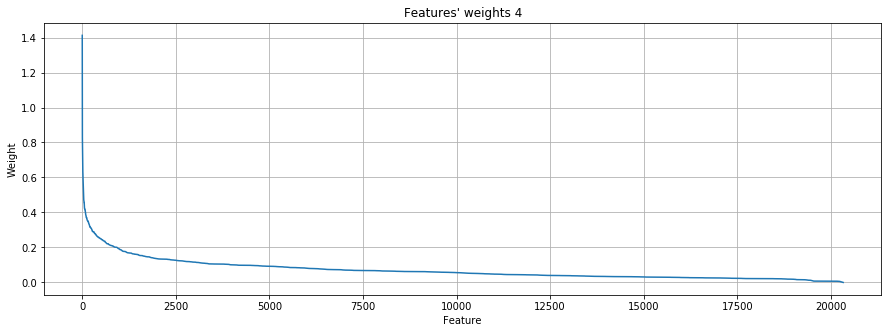

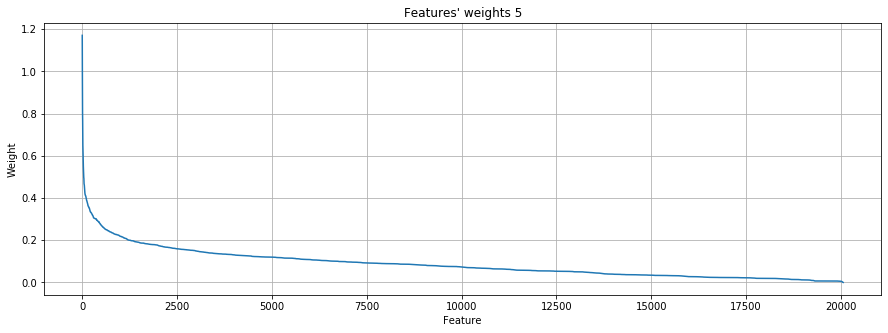

In [226]:
# Data for plotting
for i in range(weights_4l.shape[0]):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(weights_4l[i].data.shape[0]), sorted(abs(weights_4l[i].data), reverse = True))
    ax.set(xlabel='Feature', ylabel='Weight', title='Features\' weights ' + str(i))
    ax.grid()
    #fig.savefig("test.png")
    plt.show()

In [253]:
# select most important features
cutoff_0 = 0.35
selected_features_4l_0 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_4l[0].data)), weights_4l[0].indices), reverse=True) if i[0] > cutoff_0]
cutoff_1 = 0.35
selected_features_4l_1 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_4l[1].data)), weights_4l[1].indices), reverse=True) if i[0] > cutoff_1]
cutoff_2 = 0.35
selected_features_4l_2 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_4l[2].data)), weights_4l[2].indices), reverse=True) if i[0] > cutoff_2]
cutoff_3 = 0.35
selected_features_4l_3 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_4l[3].data)), weights_4l[3].indices), reverse=True) if i[0] > cutoff_3]
cutoff_4 = 0.35
selected_features_4l_4 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_4l[4].data)), weights_4l[4].indices), reverse=True) if i[0] > cutoff_4]
cutoff_5 = 0.35
selected_features_4l_5 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_4l[5].data)), weights_4l[5].indices), reverse=True) if i[0] > cutoff_5]

In [254]:
# take the union of selected features (a word important for a classification may be not important for other classifications)
selected_features_4l = set()
for f in selected_features_4l_0:
    selected_features_4l.add(f[1])
for f in selected_features_4l_1:
    selected_features_4l.add(f[1])
for f in selected_features_4l_2:
    selected_features_4l.add(f[1])
for f in selected_features_4l_3:
    selected_features_4l.add(f[1])
for f in selected_features_4l_4:
    selected_features_4l.add(f[1])
for f in selected_features_4l_5:
    selected_features_4l.add(f[1])
print('Selected ' + str(len(selected_features_4l)) + ' features')    

Selected 1617 features


Now retry grid search using only selected features

In [255]:
train_X_fs_4l = train_X_4l[:, list(selected_features_4l)]
train_y_fs_4l = train_y_4l
valid_X_fs_4l = valid_X_4l[:, list(selected_features_4l)]
valid_y_fs_4l = valid_y_4l
test_X_fs_4l = test_X_4l[:, list(selected_features_4l)]
test_y_fs_4l = test_y_4l

In [256]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_fs_4l = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_fs_4l = GridSearchCV(svm_clf_fs_4l, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_fs_4l.fit(train_X_fs_4l, train_y_fs_4l)

    print("Best parameters set found on development set:")
    print()
    print(clf_fs_4l.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_fs_4l.cv_results_['mean_test_score']
    stds = clf_fs_4l.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_fs_4l.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    4.5s finished


[LibSVM]Best parameters set found on development set:

{'C': 100.0}

Grid scores on development set:

0.240 (+/-0.000) for {'C': 0.001}
0.240 (+/-0.000) for {'C': 0.01}
0.240 (+/-0.000) for {'C': 0.1}
0.240 (+/-0.000) for {'C': 1.0}
0.352 (+/-0.051) for {'C': 10.0}
0.455 (+/-0.060) for {'C': 100.0}
0.448 (+/-0.051) for {'C': 1000.0}



In [257]:
# predictions
pred_y_fs_4l = clf_fs_4l.best_estimator_.predict(valid_X_fs_4l)

F1 macro score on validation data: 0.3867031467572415
F1 micro score on validation data: 0.8903394255874674


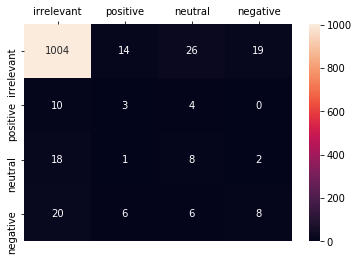

In [258]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_fs_4l, pred_y_fs_4l, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_fs_4l, pred_y_fs_4l, average='micro')))
cm = confusion_matrix(valid_y_fs_4l, pred_y_fs_4l, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

Most important features

### 0


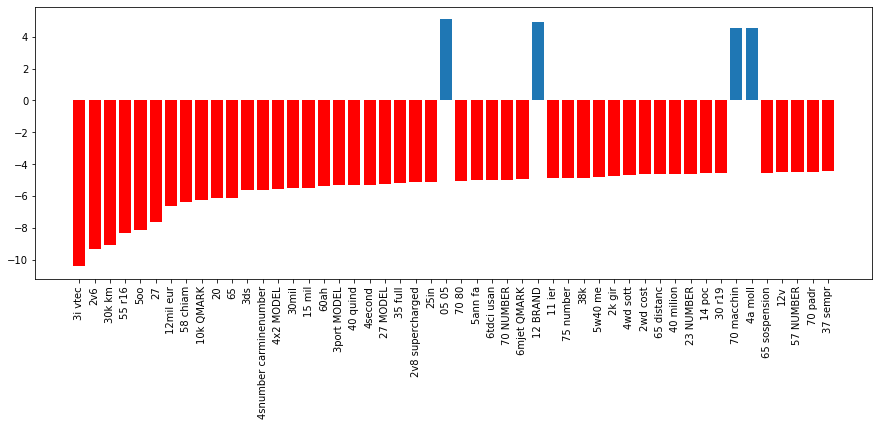

### 1


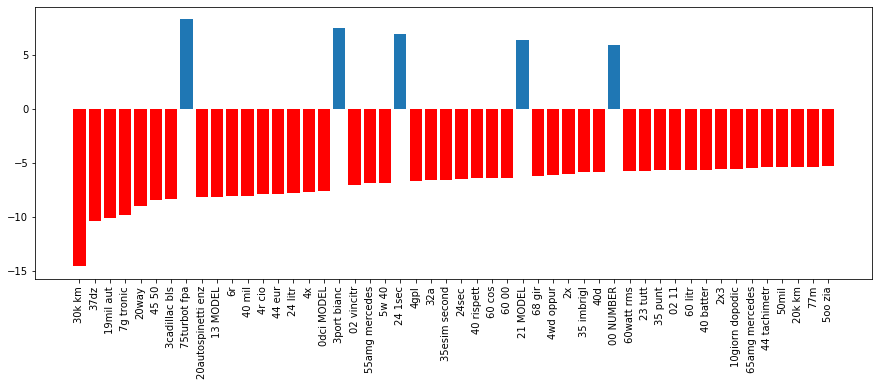

### 2


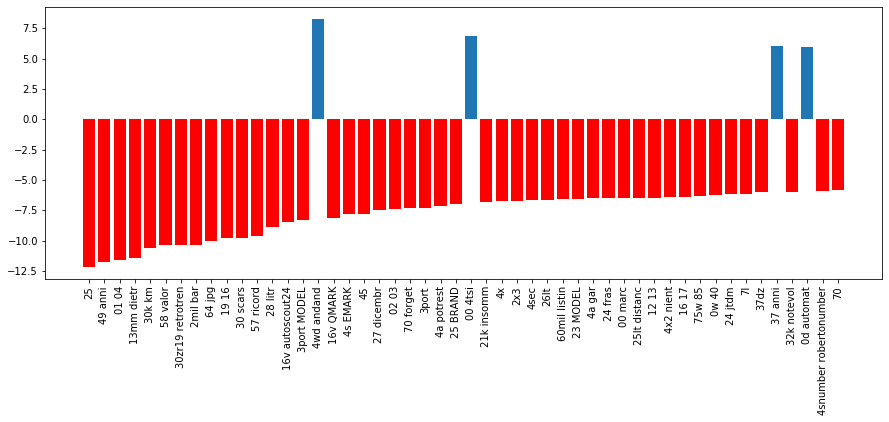

### 3


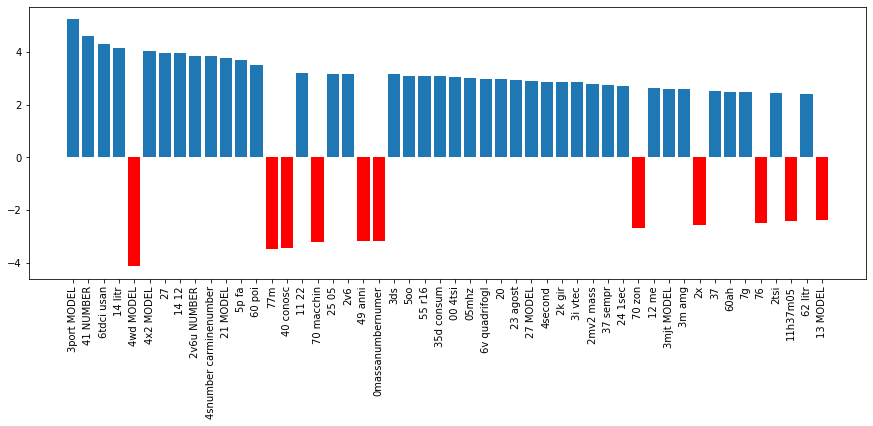

### 4


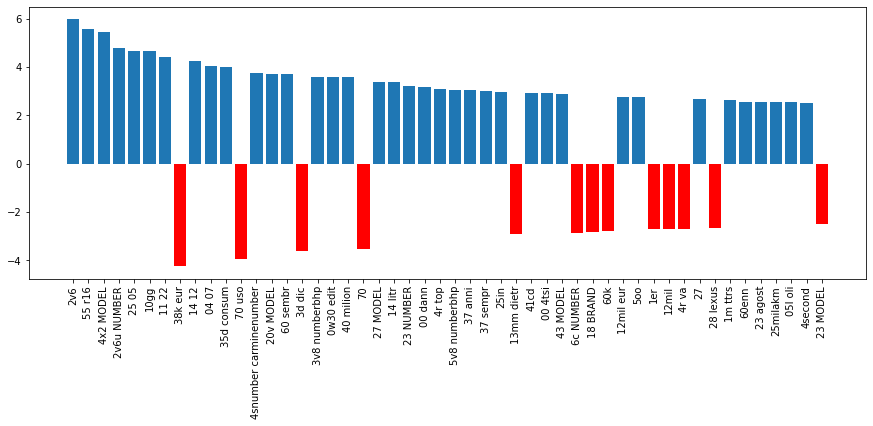

### 5


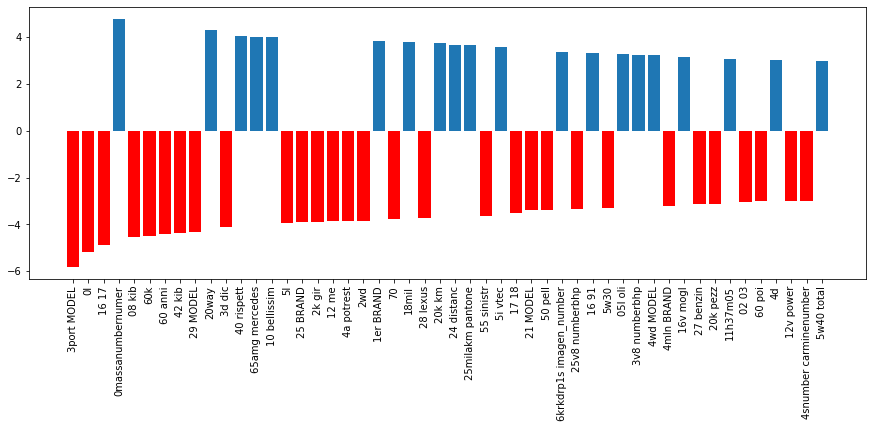

In [259]:
best_n = 50
feature_names_4l = vec_4l.get_feature_names()
for i in range(weights_4l.shape[0]):
    print('### ' + str(i))
    fn_4l = []
    fv_4l = []
    f_4l = [i for i in sorted(zip(map(lambda x: round(x, 4), clf_fs_4l.best_estimator_.coef_[i].data), clf_fs_4l.best_estimator_.coef_[i].indices), reverse=True, key=lambda k: abs(k[0]))][:best_n]
    for j in range(len(f_4l)):
        fn_4l.append(feature_names_4l[f_4l[j][1]])
        fv_4l.append(f_4l[j][0])
        #print(str(feature_names[f[j][1]]) + ': ' + str(f[j][0]))
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar([i for i in range(best_n) if fv_4l[i]>0], [x for x in fv_4l if x>0])
    plt.bar([i for i in range(best_n) if fv_4l[i]<0], [x for x in fv_4l if x<0], color='r')
    plt.xticks(range(best_n), fn_4l, rotation='vertical')
    plt.show()

## BPEF for sentiment classification

In [260]:
class Dataset:
    
    # input dataset with labels just positive/neutral/negative
    def __init__(self, text, quote, label, feature, ner=False, use_stemmer=False, combine_text_quote=False):
        if feature not in ['word', 'pos', 'swnt']:
            raise ValueError('feature parameter must be in (\'word\', \'pos\', \'swnt\')')
        self.text = text
        self.quote = quote
        self.label = label
        self.label = self.label.replace('positivo', 0)
        self.label = self.label.replace('neutro', 1)
        self.label = self.label.replace('negativo', 2)
        self.feature = feature
        self.ner = ner
        self.use_stemmer = use_stemmer
        self.combine_text_quote = combine_text_quote
        self.combined = pd.Series()
        self.vec = CountVectorizer(ngram_range=(1,2), lowercase=False)
        self.vectorized_before_fs = None
        self.vectorized_after_fs = None
        self.selected_features = None
        self.features_entropy = None
        # fit model -> transform
        self.__fit()
        self.__feature_selection()
        # apply features selection
        self.selected_features_after_fs = self.selected_features
        self.vectorized_after_fs = self.vectorized_before_fs[:, self.selected_features_after_fs]
        
        
    def __fit(self):
        # preprocess
        self.pp = Preprocessor()
        for i in range(len(self.text)):
            self.text.iloc[i] = pp.preprocessText(self.text.iloc[i], method=self.feature, use_stemmer=self.use_stemmer, ner=self.ner)
        if self.quote is not None:
            for i in range(len(self.quote)):
                self.quote.iloc[i] = pp.preprocessText(self.quote.iloc[i], method=self.feature, use_stemmer=self.use_stemmer, ner=self.ner)
        # combine text quote
        if self.quote is not None:
            for i in range(len(self.text)):
                comb = combine_text_quote(self.text.iloc[i], self.quote.iloc[i], divide_quote=self.combine_text_quote)
                self.combined.loc[i] = comb
        else:
            self.combined = self.text
        # vectorization (count vectorizer vediamo)
        self.vectorized_before_fs = self.vec.fit_transform(self.combined)
        
            
    def transform(self, text, quote):
        combined = pd.Series()
        for i in range(len(text)):
            text.iloc[i] = self.pp.preprocessText(text.iloc[i], method=self.feature, use_stemmer=self.use_stemmer, ner=self.ner)
        if quote is not None:
            for i in range(len(quote)):
                quote.iloc[i] = self.pp.preprocessText(quote.iloc[i], method=self.feature, use_stemmer=self.use_stemmer, ner=self.ner)
        # combine text quote
        if quote is not None:
            for i in range(len(text)):
                comb = combine_text_quote(text.iloc[i], quote.iloc[i], divide_quote=self.combine_text_quote)
                combined.loc[i] = comb
        else:
            combined = text
        # vectorization (count vectorizer vediamo) and feature selection
        vectorized = self.vec.transform(combined)[:, self.selected_features_after_fs]
        return vectorized
    
    # https://www3.nd.edu/~rjohns15/cse40647.sp14/www/content/lectures/23%20-%20Decision%20Trees%202.pdf
    # https://pypi.org/project/info-gain/
    def __feature_selection(self):
        self.selected_features = [i for i in range(self.vectorized_before_fs.shape[1])]
        self.features_entropy = []
        
        #H_class = scipy.stats.entropy(self.label.value_counts())
        
        # for each feature calculate information gain
        for feat_idx in range(self.vectorized_before_fs.shape[1]):
            # print
            sys.stdout.write("\r IG: " + str(feat_idx) + '/' + str(self.vectorized_before_fs.shape[1]-1))
            sys.stdout.flush()
            '''
            H_feat = 0
            values = set(np.append(self.vectorized_before_fs[:, feat_idx].data, 0)) # zero added manually bcause sparse matrix is stupid
            # for each value calculate the conditional entropy
            for v in values:
                indexes = [i for i in range(self.vectorized_before_fs.shape[0]) if self.vectorized_before_fs[i, feat_idx] == v]
                feat_list = self.label[indexes]
                # entropy
                feat_prob = len(feat_list) / self.vectorized_before_fs.shape[0]
                H_feat += feat_prob * scipy.stats.entropy(feat_list.value_counts())
            #print(H_feat)
            # information gain of the feature
            IG = H_class - H_feat
            '''
            IG = info_gain.info_gain(self.label, self.vectorized_before_fs[:, feat_idx].toarray().ravel())
            self.features_entropy.append(IG)
            
    def plot_IG_feature(self):
        plot_ig = sorted(self.features_entropy, reverse=True)
        plt.subplots(figsize=(15,5))
        plt.semilogy(range(len(plot_ig)), plot_ig)
        plt.show()
        
    def cut_features(self, cutoff_value):
        # cut and apply features selection
        self.selected_features_after_fs = [i for i in range(len(self.features_entropy)) if self.features_entropy[i] > cutoff_value]
        self.vectorized_after_fs = self.vectorized_before_fs[:, self.selected_features_after_fs]
        

### BPEF

Create dataset dictionary

In [262]:
np.random.seed(42)

dataset_bpef = original_dataset.copy(deep=True)
# split 80% training and 20% test
train_dataset_X_bpef, test_dataset_X_bpef, train_dataset_y_bpef, test_dataset_y_bpef = train_test_split(dataset_bpef[['TESTO', '(Testo Citato)']], dataset_bpef[column], test_size=0.2, stratify=dataset_bpef[column], shuffle=True, random_state=52)
# split validation
train_dataset_X_bpef, valid_dataset_X_bpef, train_dataset_y_bpef, valid_dataset_y_bpef = train_test_split(train_dataset_X_bpef, train_dataset_y_bpef, test_size=0.2, stratify=train_dataset_y_bpef, shuffle=True, random_state=52)

train_dataset_X_bpef = train_dataset_X_bpef[train_dataset_y_bpef != 'irrilevante']
train_dataset_y_bpef = train_dataset_y_bpef[train_dataset_y_bpef != 'irrilevante']
valid_dataset_X_bpef = valid_dataset_X_bpef[valid_dataset_y_bpef != 'irrilevante']
valid_dataset_y_bpef = valid_dataset_y_bpef[valid_dataset_y_bpef != 'irrilevante']
test_dataset_X_bpef = test_dataset_X_bpef[test_dataset_y_bpef != 'irrilevante']
test_dataset_y_bpef = test_dataset_y_bpef[test_dataset_y_bpef != 'irrilevante']

In [263]:
collections.Counter(train_dataset_y_bpef)

Counter({'neutro': 117,
         'negativo': 118,
         'positivo': 59,
         'molto positivo': 11,
         'molto negativo': 39})

word False
 IG: 28586/28586

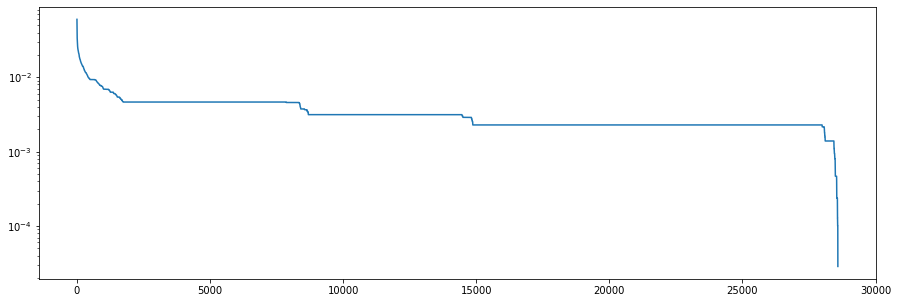

word True
 IG: 27144/27144

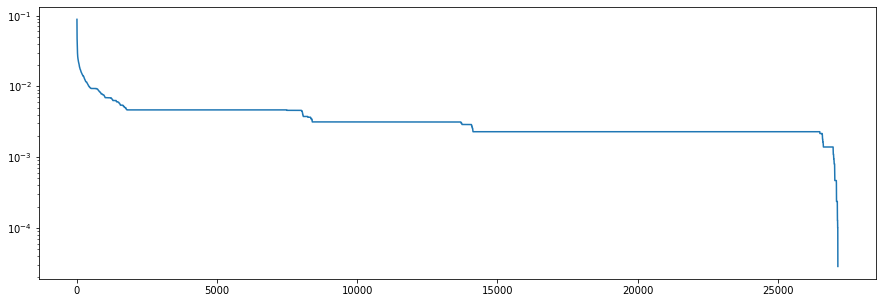

pos False
 IG: 32969/32969

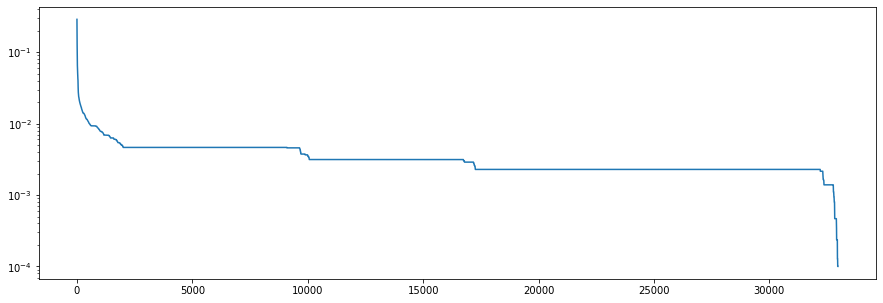

pos True
 IG: 31226/31226

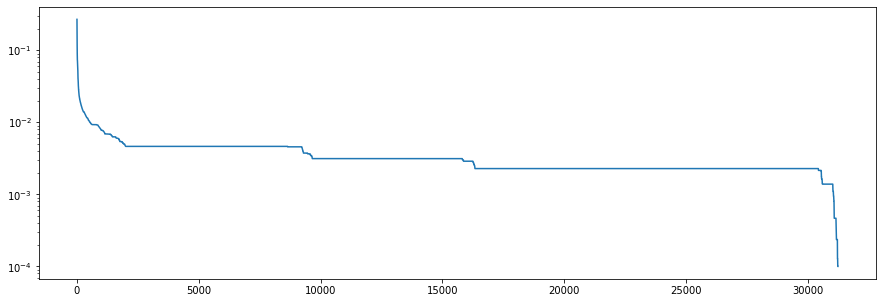

swnt False
 IG: 24509/24509

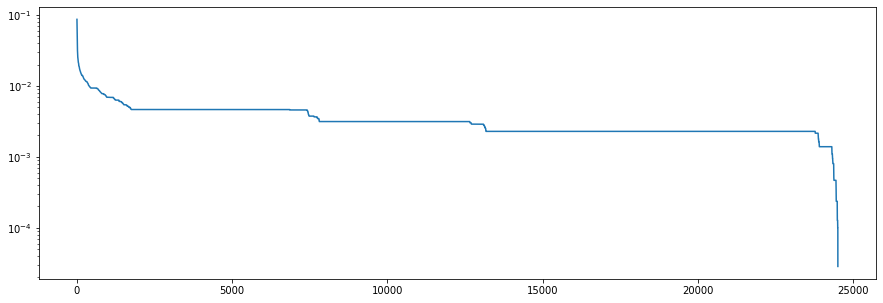

swnt True
 IG: 23074/23074

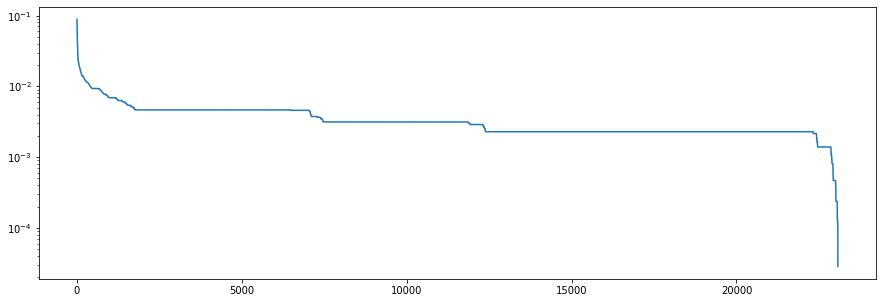

In [264]:
feature_values = ['word', 'pos', 'swnt']
ner_values = [False, True]

train_X_bpef = train_dataset_X_bpef
train_y_bpef = train_dataset_y_bpef.replace('positivo', 1).replace('neutro', 2).replace('negativo', 3).replace('molto positivo', 1).replace('molto negativo', 3)
valid_X_bpef = valid_dataset_X_bpef
valid_y_bpef = valid_dataset_y_bpef.replace('positivo', 1).replace('neutro', 2).replace('negativo', 3).replace('molto positivo', 1).replace('molto negativo', 3)
test_X_bpef = test_dataset_X_bpef
test_y_bpef = test_dataset_y_bpef.replace('positivo', 1).replace('neutro', 2).replace('negativo', 3).replace('molto positivo', 1).replace('molto negativo', 3)


dataset_dict = {}
for f in feature_values:
    for n in ner_values:
        print(f + ' ' + str(n))
        
        d = Dataset(text=train_X_bpef['TESTO'].copy(deep=True), quote=train_X_bpef['(Testo Citato)'].copy(deep=True), label=train_y_bpef.copy(), feature=f, ner=n, use_stemmer=True, combine_text_quote=False)
        
        d.plot_IG_feature()
        dataset_dict[(f, n)] = d


In [266]:
sorted(dataset_dict[('word', False)].features_entropy, reverse=True)[6000]

0.004644966954323593

In [267]:
# dataset no feature selection
dataset_dict_nofs = copy(dataset_dict)

In [268]:
# without feature selection
for k in dataset_dict_nofs.keys():
    dataset_dict_nofs[k].cut_features(0)
    print(str(k) + ' ' + str(len(dataset_dict_nofs[k].selected_features_after_fs)))

('word', False) 28587
('word', True) 27145
('pos', False) 32970
('pos', True) 31227
('swnt', False) 24510
('swnt', True) 23075


In [269]:
class BPEF:
    
    def __init__(self, dict_dataset):
        self.dict_dataset = dict_dataset
        
    # text plain, quote plain, labels numerical
    def train(self, text, quote, labels):
        self.classifiers_dict = {}
        keys = self.dict_dataset.keys()
        classifiers = ['svm', 'logreg', 'naibay', 'rndfst']
        # for each feature type -> keys ('feature', True/False)
        for k in keys:
            d = self.dict_dataset[k]
            # train set
            text_copy = text.copy(deep=True)
            quote_copy = quote.copy(deep=True)
            X = d.transform(text_copy, quote_copy)
            # train every classifier
            for c in classifiers:
                print('######## ' + str((k + (c, ))) + ' ########')
                
                if c == 'svm':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    svmclf = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)
                    tuned_parameters = {'C': np.logspace(-3, 3, 7),}
                    clf = GridSearchCV(svmclf, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X, labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
                    
                elif c == 'logreg':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    logreg = LogisticRegression(multi_class='ovr', verbose=2, random_state=42)
                    tuned_parameters = {'C': np.logspace(-3, 3, 7)}
                    clf = GridSearchCV(logreg, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X, labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
                    
                elif c == 'naibay':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    naibay = GaussianNB()
                    tuned_parameters = {}
                    clf = GridSearchCV(naibay, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X.toarray(), labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
                    
                elif c == 'rndfst':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    rndfst = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)
                    tuned_parameters = {'n_estimators': [201,501], 'max_features': ['auto', 'log2'], 'max_depth' : [10, 100], 'criterion' :['gini', 'entropy']}
                    clf = GridSearchCV(rndfst, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X.toarray(), labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
            
        
    # text quote plain
    def predict(self, text, quote):
        text_copy = text.copy(deep=True)
        quote_copy = quote.copy(deep=True)
        predictions = {}
        keys = self.dict_dataset.keys()
        classifiers = ['svm', 'logreg', 'naibay', 'rndfst']
        for k in keys:
            d = self.dict_dataset[k]
            # train set
            text_copy = text.copy(deep=True)
            quote_copy = quote.copy(deep=True)
            X = d.transform(text_copy, quote_copy)
            # train every classifier
            for c in classifiers:
                print('######## ' + str((k + (c, ))) + ' ########')
                # make prediction
                pred = self.classifiers_dict[k + (c, )].predict(X.toarray())
                predictions[k + (c, )] = pred
        # calculate the ensemble
        fin_pred = []
        for i in range(text_copy.shape[0]):
            curr_pred = []
            for k in keys:
                for c in classifiers:
                    curr_pred.append(predictions[k + (c, )][i])
            fin_pred.append(max(set(curr_pred), key = curr_pred.count))
        return fin_pred
                

without feature selection

In [270]:
bpef_nofs = BPEF(dataset_dict_nofs)

In [271]:
bpef_nofs.train(train_X_bpef['TESTO'], train_X_bpef['(Testo Citato)'], train_y_bpef)

######## ('word', False, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.209 (+/-0.000) for {'C': 0.001}
0.376 (+/-0.060) for {'C': 0.01}
0.441 (+/-0.051) for {'C': 0.1}
0.422 (+/-0.055) for {'C': 1.0}
0.422 (+/-0.055) for {'C': 10.0}
0.422 (+/-0.055) for {'C': 100.0}
0.422 (+/-0.055) for {'C': 1000.0}

######## ('word', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]Best parameters set found on development set:

{'C': 100.0}

Grid scores on development set:

0.209 (+/-0.000) for {'C': 0.001}
0.348 (+/-0.075) for {'C': 0.01}
0.414 (+/-0.109) for {'C': 0.1}
0.413 (+/-0.077) for {'C': 1.0}
0.400 (+/-0.085) for {'C': 10.0}
0.420 (+/-0.060) for {'C': 100.0}
0.414 (+/-0.041) for {'C': 1000.0}

######## ('word', False, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.373 (+/-0.137) for {}

######## ('word', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}

Grid scores on development set:

0.251 (+/-0.112) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.209 (+/-0.000) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.209 (+/-0.000) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.209 (+/-0.000) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.371 (+/-0.037) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.378 (+/-0.040) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.371 (+/-0.040) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.374 (+/-0.030) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estim

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.224 (+/-0.038) for {'C': 0.001}
0.345 (+/-0.090) for {'C': 0.01}
0.442 (+/-0.084) for {'C': 0.1}
0.442 (+/-0.060) for {'C': 1.0}
0.442 (+/-0.060) for {'C': 10.0}
0.442 (+/-0.060) for {'C': 100.0}
0.442 (+/-0.060) for {'C': 1000.0}

######## ('word', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 100.0}

Grid scores on development set:

0.225 (+/-0.026) for {'C': 0.001}
0.358 (+/-0.088) for {'C': 0.01}
0.406 (+/-0.063) for {'C': 0.1}
0.412 (+/-0.050) for {'C': 1.0}
0.429 (+/-0.097) for {'C': 10.0}
0.434 (+/-0.096) for {'C': 100.0}
0.422 (+/-0.088) for {'C': 1000.0}

######## ('word', True, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{}

Grid scores on development set:

0.371 (+/-0.122) for {}

######## ('word', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}

Grid scores on development set:

0.237 (+/-0.084) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.220 (+/-0.045) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.209 (+/-0.000) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.209 (+/-0.000) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.368 (+/-0.048) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.382 (+/-0.042) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.396 (+/-0.049) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.383 (+/-0.060) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.264 (+/-0.074) for {'C': 0.001}
0.446 (+/-0.175) for {'C': 0.01}
0.478 (+/-0.137) for {'C': 0.1}
0.485 (+/-0.144) for {'C': 1.0}
0.485 (+/-0.144) for {'C': 10.0}
0.485 (+/-0.144) for {'C': 100.0}
0.485 (+/-0.144) for {'C': 1000.0}

######## ('pos', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    1.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]Best parameters set found on development set:

{'C': 1000.0}

Grid scores on development set:

0.367 (+/-0.068) for {'C': 0.001}
0.399 (+/-0.077) for {'C': 0.01}
0.430 (+/-0.055) for {'C': 0.1}
0.457 (+/-0.088) for {'C': 1.0}
0.454 (+/-0.099) for {'C': 10.0}
0.456 (+/-0.105) for {'C': 100.0}
0.459 (+/-0.122) for {'C': 1000.0}

######## ('pos', False, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{}

Grid scores on development set:

0.351 (+/-0.131) for {}

######## ('pos', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}

Grid scores on development set:

0.360 (+/-0.077) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.366 (+/-0.080) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.209 (+/-0.000) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.209 (+/-0.000) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.401 (+/-0.068) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.401 (+/-0.068) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.386 (+/-0.070) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.383 (+/-0.082) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.249 (+/-0.059) for {'C': 0.001}
0.431 (+/-0.178) for {'C': 0.01}
0.455 (+/-0.135) for {'C': 0.1}
0.455 (+/-0.145) for {'C': 1.0}
0.455 (+/-0.145) for {'C': 10.0}
0.455 (+/-0.145) for {'C': 100.0}
0.455 (+/-0.145) for {'C': 1000.0}

######## ('pos', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    1.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]Best parameters set found on development set:

{'C': 1000.0}

Grid scores on development set:

0.373 (+/-0.079) for {'C': 0.001}
0.403 (+/-0.066) for {'C': 0.01}
0.427 (+/-0.103) for {'C': 0.1}
0.432 (+/-0.161) for {'C': 1.0}
0.425 (+/-0.152) for {'C': 10.0}
0.438 (+/-0.136) for {'C': 100.0}
0.439 (+/-0.157) for {'C': 1000.0}

######## ('pos', True, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.359 (+/-0.047) for {}

######## ('pos', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}

Grid scores on development set:

0.370 (+/-0.072) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.364 (+/-0.064) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.209 (+/-0.000) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.209 (+/-0.000) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.400 (+/-0.089) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.402 (+/-0.065) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.381 (+/-0.075) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.381 (+/-0.085) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.218 (+/-0.037) for {'C': 0.001}
0.383 (+/-0.142) for {'C': 0.01}
0.421 (+/-0.126) for {'C': 0.1}
0.414 (+/-0.123) for {'C': 1.0}
0.414 (+/-0.123) for {'C': 10.0}
0.414 (+/-0.123) for {'C': 100.0}
0.414 (+/-0.123) for {'C': 1000.0}

######## ('swnt', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.229 (+/-0.060) for {'C': 0.001}
0.370 (+/-0.063) for {'C': 0.01}
0.383 (+/-0.064) for {'C': 0.1}
0.393 (+/-0.116) for {'C': 1.0}
0.395 (+/-0.111) for {'C': 10.0}
0.386 (+/-0.104) for {'C': 100.0}
0.386 (+/-0.130) for {'C': 1000.0}

######## ('swnt', False, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.367 (+/-0.082) for {}

######## ('swnt', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}

Grid scores on development set:

0.279 (+/-0.106) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.289 (+/-0.119) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.209 (+/-0.000) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.209 (+/-0.000) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.377 (+/-0.047) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.384 (+/-0.051) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.375 (+/-0.062) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.386 (+/-0.051) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estim

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.7s remaining:    0.5s


[LibSVM]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.224 (+/-0.038) for {'C': 0.001}
0.371 (+/-0.079) for {'C': 0.01}
0.468 (+/-0.139) for {'C': 0.1}
0.472 (+/-0.145) for {'C': 1.0}
0.472 (+/-0.145) for {'C': 10.0}
0.472 (+/-0.145) for {'C': 100.0}
0.472 (+/-0.145) for {'C': 1000.0}

######## ('swnt', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
 

[LibLinear]Best parameters set found on development set:

{'C': 100.0}

Grid scores on development set:

0.240 (+/-0.066) for {'C': 0.001}
0.371 (+/-0.076) for {'C': 0.01}
0.389 (+/-0.080) for {'C': 0.1}
0.406 (+/-0.096) for {'C': 1.0}
0.416 (+/-0.094) for {'C': 10.0}
0.432 (+/-0.098) for {'C': 100.0}
0.412 (+/-0.117) for {'C': 1000.0}

######## ('swnt', True, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{}

Grid scores on development set:

0.324 (+/-0.093) for {}

######## ('swnt', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}

Grid scores on development set:

0.314 (+/-0.065) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.320 (+/-0.057) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.209 (+/-0.000) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.209 (+/-0.000) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.384 (+/-0.048) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.399 (+/-0.059) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.377 (+/-0.050) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.386 (+/-0.070) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

In [272]:
pred_nofs = bpef_nofs.predict(valid_X_bpef['TESTO'], valid_X_bpef['(Testo Citato)'])

######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, '

F1 macro score on validation data: 0.38874794456189804
F1 micro score on validation data: 0.4883720930232558


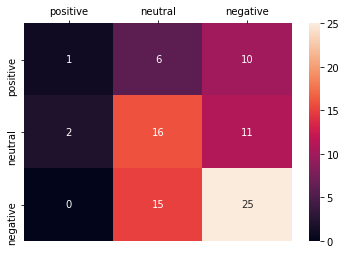

In [273]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_bpef, pred_nofs, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_bpef, pred_nofs, average='micro')))
cm_fs_bpef_nofs = confusion_matrix(valid_y_bpef, pred_nofs, labels=[1, 2, 3])
ax = sns.heatmap(cm_fs_bpef_nofs, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'])
ax.xaxis.set_ticks_position('top')

In [301]:
# feature selection
# cut less informative features -> cutoff at 0.0019 (heuristic)
for k in dataset_dict.keys():
    dataset_dict[k].cut_features(0.005)
    print(str(k) + ' ' + str(len(dataset_dict[k].selected_features_after_fs)))

('word', False) 1671
('word', True) 1719
('pos', False) 1940
('pos', True) 1937
('swnt', False) 1686
('swnt', True) 1708


With feature selection

In [302]:
bpef = BPEF(dataset_dict)

In [303]:
bpef.train(train_X_bpef['TESTO'], train_X_bpef['(Testo Citato)'], train_y_bpef)

######## ('word', False, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.209 (+/-0.000) for {'C': 0.001}
0.306 (+/-0.119) for {'C': 0.01}
0.493 (+/-0.086) for {'C': 0.1}
0.454 (+/-0.085) for {'C': 1.0}
0.468 (+/-0.083) for {'C': 10.0}
0.468 (+/-0.083) for {'C': 100.0}
0.468 (+/-0.083) for {'C': 1000.0}

######## ('word', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.209 (+/-0.000) for {'C': 0.001}
0.370 (+/-0.144) for {'C': 0.01}
0.462 (+/-0.104) for {'C': 0.1}
0.488 (+/-0.056) for {'C': 1.0}
0.487 (+/-0.053) for {'C': 10.0}
0.482 (+/-0.020) for {'C': 100.0}
0.476 (+/-0.048) for {'C': 1000.0}

######## ('word', False, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters set found on development set:

{}

Grid scores on development set:

0.536 (+/-0.065) for {}

######## ('word', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 501}

Grid scores on development set:

0.404 (+/-0.049) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.399 (+/-0.060) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.280 (+/-0.144) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.265 (+/-0.122) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.393 (+/-0.076) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.396 (+/-0.066) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.397 (+/-0.079) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.408 (+/-0.084) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.224 (+/-0.038) for {'C': 0.001}
0.266 (+/-0.105) for {'C': 0.01}
0.476 (+/-0.080) for {'C': 0.1}
0.443 (+/-0.053) for {'C': 1.0}
0.447 (+/-0.088) for {'C': 10.0}
0.447 (+/-0.088) for {'C': 100.0}
0.447 (+/-0.088) for {'C': 1000.0}

######## ('word', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `i

[LibLinear]Best parameters set found on development set:

{'C': 100.0}

Grid scores on development set:

0.225 (+/-0.026) for {'C': 0.001}
0.372 (+/-0.096) for {'C': 0.01}
0.470 (+/-0.119) for {'C': 0.1}
0.467 (+/-0.107) for {'C': 1.0}
0.468 (+/-0.109) for {'C': 10.0}
0.473 (+/-0.086) for {'C': 100.0}
0.453 (+/-0.074) for {'C': 1000.0}

######## ('word', True, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters set found on development set:

{}

Grid scores on development set:

0.565 (+/-0.054) for {}

######## ('word', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   18.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}

Grid scores on development set:

0.389 (+/-0.038) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.406 (+/-0.055) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.289 (+/-0.133) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.261 (+/-0.092) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.411 (+/-0.073) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.400 (+/-0.045) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.418 (+/-0.057) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.400 (+/-0.062) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estima

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.266 (+/-0.075) for {'C': 0.001}
0.430 (+/-0.104) for {'C': 0.01}
0.458 (+/-0.107) for {'C': 0.1}
0.442 (+/-0.062) for {'C': 1.0}
0.442 (+/-0.062) for {'C': 10.0}
0.442 (+/-0.062) for {'C': 100.0}
0.442 (+/-0.062) for {'C': 1000.0}

######## ('pos', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `i

[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.367 (+/-0.067) for {'C': 0.001}
0.420 (+/-0.104) for {'C': 0.01}
0.447 (+/-0.082) for {'C': 0.1}
0.452 (+/-0.066) for {'C': 1.0}
0.443 (+/-0.072) for {'C': 10.0}
0.445 (+/-0.075) for {'C': 100.0}
0.424 (+/-0.061) for {'C': 1000.0}

######## ('pos', False, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters set found on development set:

{}

Grid scores on development set:

0.588 (+/-0.074) for {}

######## ('pos', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}

Grid scores on development set:

0.412 (+/-0.077) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.410 (+/-0.081) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.416 (+/-0.090) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.401 (+/-0.082) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.402 (+/-0.094) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.416 (+/-0.093) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.403 (+/-0.078) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.400 (+/-0.080) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estima

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.253 (+/-0.065) for {'C': 0.001}
0.421 (+/-0.177) for {'C': 0.01}
0.442 (+/-0.089) for {'C': 0.1}
0.444 (+/-0.091) for {'C': 1.0}
0.451 (+/-0.081) for {'C': 10.0}
0.451 (+/-0.081) for {'C': 100.0}
0.451 (+/-0.081) for {'C': 1000.0}

######## ('pos', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.368 (+/-0.101) for {'C': 0.001}
0.407 (+/-0.055) for {'C': 0.01}
0.447 (+/-0.114) for {'C': 0.1}
0.454 (+/-0.132) for {'C': 1.0}
0.464 (+/-0.135) for {'C': 10.0}
0.447 (+/-0.124) for {'C': 100.0}
0.445 (+/-0.102) for {'C': 1000.0}

######## ('pos', True, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters set found on development set:

{}

Grid scores on development set:

0.630 (+/-0.029) for {}

######## ('pos', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   18.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}

Grid scores on development set:

0.413 (+/-0.114) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.416 (+/-0.074) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.392 (+/-0.075) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.394 (+/-0.052) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.406 (+/-0.067) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.422 (+/-0.084) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.388 (+/-0.087) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.412 (+/-0.071) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.218 (+/-0.037) for {'C': 0.001}
0.395 (+/-0.093) for {'C': 0.01}
0.455 (+/-0.098) for {'C': 0.1}
0.440 (+/-0.112) for {'C': 1.0}
0.444 (+/-0.117) for {'C': 10.0}
0.444 (+/-0.117) for {'C': 100.0}
0.444 (+/-0.117) for {'C': 1000.0}

######## ('swnt', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.229 (+/-0.060) for {'C': 0.001}
0.363 (+/-0.069) for {'C': 0.01}
0.427 (+/-0.121) for {'C': 0.1}
0.445 (+/-0.108) for {'C': 1.0}
0.468 (+/-0.104) for {'C': 10.0}
0.439 (+/-0.099) for {'C': 100.0}
0.435 (+/-0.102) for {'C': 1000.0}

######## ('swnt', False, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters set found on development set:

{}

Grid scores on development set:

0.573 (+/-0.031) for {}

######## ('swnt', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}

Grid scores on development set:

0.391 (+/-0.046) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.397 (+/-0.039) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.354 (+/-0.048) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.359 (+/-0.055) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.392 (+/-0.040) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.397 (+/-0.052) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.393 (+/-0.049) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.395 (+/-0.031) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estima

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.224 (+/-0.038) for {'C': 0.001}
0.390 (+/-0.132) for {'C': 0.01}
0.478 (+/-0.131) for {'C': 0.1}
0.452 (+/-0.153) for {'C': 1.0}
0.444 (+/-0.141) for {'C': 10.0}
0.444 (+/-0.141) for {'C': 100.0}
0.444 (+/-0.141) for {'C': 1000.0}

######## ('swnt', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `i

[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.264 (+/-0.081) for {'C': 0.001}
0.385 (+/-0.044) for {'C': 0.01}
0.435 (+/-0.106) for {'C': 0.1}
0.442 (+/-0.115) for {'C': 1.0}
0.432 (+/-0.130) for {'C': 10.0}
0.428 (+/-0.150) for {'C': 100.0}
0.435 (+/-0.149) for {'C': 1000.0}

######## ('swnt', True, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters set found on development set:

{}

Grid scores on development set:

0.587 (+/-0.070) for {}

######## ('swnt', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 501}

Grid scores on development set:

0.389 (+/-0.048) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.394 (+/-0.055) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.335 (+/-0.061) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.334 (+/-0.092) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.400 (+/-0.059) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.396 (+/-0.062) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.400 (+/-0.079) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.404 (+/-0.070) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

In [304]:
pred = bpef.predict(valid_X_bpef['TESTO'], valid_X_bpef['(Testo Citato)'])

######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, '

F1 macro score on validation data: 0.41998613555164505
F1 micro score on validation data: 0.47674418604651164


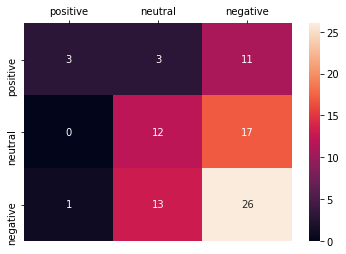

In [305]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_bpef, pred, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_bpef, pred, average='micro')))
cm_fs_bpef = confusion_matrix(valid_y_bpef, pred, labels=[1, 2, 3])
ax = sns.heatmap(cm_fs_bpef, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'])
ax.xaxis.set_ticks_position('top')

In [306]:
print('positive: ' + str(list(train_y_bpef).count(1)))
print('neutral: ' + str(list(train_y_bpef).count(2)))
print('negative: ' + str(list(train_y_bpef).count(3)))

positive: 70
neutral: 117
negative: 157


Some errors

In [307]:
valid_X_bpef.iloc[0]

TESTO             Non so appena posso chiedo in conce e si vedr\...
(Testo Citato)                                                     
Name: 6128, dtype: object

In [357]:
# positive predicted negative
err_pos_neu = [i for i in range(valid_y_bpef.shape[0]) if valid_y_bpef.iloc[i]==1 and pred[i]==3]
print(valid_X_bpef['TESTO'].iloc[err_pos_neu[1]])
print('################################################################')
print(valid_X_bpef['(Testo Citato)'].iloc[err_pos_neu[1]])

L'ho vista pure io visto che ero al Fox Town....beh incrociandola non \xe8 cos\xec brutta come sembra in foto il muso \xe8 imponente. Per il posteriore concordo che potevano impegnarsi molto di pi\xf9 i designer soprattutto aggiungere un simil estrattore al paraurti post. Aston Martin Rapide insegna...
################################################################



In [308]:
# neutral predicted negative
err_neu_pos = [i for i in range(valid_y_bpef.shape[0]) if valid_y_bpef.iloc[i]==2 and pred[i]==3]
print(valid_X_bpef['TESTO'].iloc[err_neu_pos[1]])
print('################################################################')
print(valid_X_bpef['(Testo Citato)'].iloc[err_neu_pos[1]])

ottimo prezzo ! dove l'hai presa ? hai messo anche il pack ex ? 
################################################################
"Salve sono un felice possessore di una kia 1.2 ex bianca con sensori di parcheggio. L'ho ritirata lunedì e che dir un'auto splendida! Nemmeno una pecc mille volte meglio di una punto (ormai dal 2006 sempre la stessa cambiano solo paraurti e qualche fesseria all'interno) o qualsiasi altra marca sempre a parità di prezzo. Io l'ho presa 10900? in pronta consegna e con i sensori omaggi e a questo prezzo nessun'altra casa sapeva darmi di meglio. Il punto è quest sabato ho portato la macchina al lavaggio (rigorosamente a mano!) e al momento della finale asciugatura ho notato un pò di vapore all'interno dei far cosa che non dovrebbe fare. E' successo a qualcun'altro? Io per si e per no in settimana vedo di fare entrare la macchina in officina e farle dare un controllo. comunque allego una foto. Grazie a tutti!"


In [309]:
# negative predicted neutral
err_neg_pos = [i for i in range(valid_y_bpef.shape[0]) if valid_y_bpef.iloc[i]==3 and pred[i]==2]
print(valid_X_bpef['TESTO'].iloc[err_neg_pos[2]])
print('################################################################')
print(valid_X_bpef['(Testo Citato)'].iloc[err_neg_pos[2]])

Sicuro poco veramente. Ma secondo voi in Skoda non prendono in esame queste differenze tra concessionari per chiedere lumi su tali differenze :shock: :shock: 
################################################################
'Beh te la sei cavata relativamente con poco.'


### 4 label cascade classifier

In [310]:
# valid_y_4l validation dataset
collections.Counter(valid_y_4l)

Counter({0: 1063, 3: 40, 2: 29, 1: 17})

In [311]:
# use validation set of 4 labels classifier
valid_idx = list(valid_y_4l.index)
valid_dataset_X_cas = original_dataset.loc[valid_idx]
valid_dataset_X_cas

,TESTO,(Testo Citato),Assistenza/Concessionari
3170,esiste già http://forum.quattroruote.it/posts/...,,irrilevante
1423,in effetti è strano anche che a 110mila km dia...,'Io ho fatto via fax la richiesta cronologica ...,irrilevante
3492,fossero solo i sedili...questi hanno riciclato...,,irrilevante
6847,Comunque se non ti pesa troppo io la terrei.,,irrilevante
2218,..Lancia produceva ancora questo esemplare.. ....,,irrilevante
7173,Inoltre derivavano direttamente dalle corse in...,,irrilevante
422,sergio devi dirci che tipo di cerchi sono se T...,,irrilevante
226,ma tieniti quella che hai è bellissima ! ! !,,irrilevante
428,è contagiosissimo...al museo BMW ho fatto più ...,' a quando per i tuoi acquisti?',irrilevante
2010,Stavo pensando di passare a 500. Ma sono sconv...,,irrilevante


irrelevant / relevant

In [312]:
# irrelevant / relevant
valid_dataset_X_cas_svm = valid_dataset_X_cas.copy(deep=True)
pp = Preprocessor()
# TESTO
for i in range(valid_dataset_X_cas_svm.shape[0]):
    valid_dataset_X_cas_svm['TESTO'].iloc[i] = pp.preprocessText(valid_dataset_X_cas_svm['TESTO'].iloc[i], method='word', use_stemmer=True, ner=True)
# (Testo Citato)
for i in range(valid_dataset_X_cas_svm.shape[0]):
    valid_dataset_X_cas_svm['(Testo Citato)'].iloc[i] = pp.preprocessText(valid_dataset_X_cas_svm['(Testo Citato)'].iloc[i], method='word', use_stemmer=True, ner=True)    

In [313]:
valid_concat_svm = []
for i in range(len(valid_dataset_X_cas_svm)):
    valid_concat_svm.append(combine_text_quote(valid_dataset_X_cas_svm['TESTO'].iloc[i], valid_dataset_X_cas_svm['(Testo Citato)'].iloc[i], divide_quote=False))

In [314]:
# predict irrelevant/relevant
valid_X_cas_svm = vec_logreg.transform(valid_concat_svm)
valid_X_cas_svm_fs = valid_X_cas_svm[:, list(selected_features_logreg)]

In [315]:
pred_cas_svm_ir = clf_logreg_fs.best_estimator_.predict(valid_X_cas_svm_fs)

sentiment with SVM

In [316]:
for i in range(len(pred_cas_svm_ir)):
    if pred_cas_svm_ir[i] == 1:
        v = vec_snt.transform([valid_concat_svm[i]])
        v_fs = v[0,list(selected_features_snt)]
        p = clf_fs_snt.best_estimator_.predict(v_fs)
        pred_cas_svm_ir[i] = p

In [317]:
collections.Counter(pred_cas_svm_ir)

Counter({0: 1049, 3: 66, 2: 23, 1: 11})

In [318]:
valid_true = valid_dataset_X_cas[column].replace('irrilevante', 0).replace('positivo', 1).replace('neutro', 2).replace('negativo', 3).replace('molto positivo', 1).replace('molto negativo', 3).tolist()

F1 macro score on validation data: 0.41062126749037126
F1 micro score on validation data: 0.897302001740644


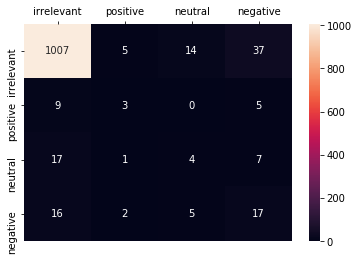

In [319]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_true, pred_cas_svm_ir, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_true, pred_cas_svm_ir, average='micro')))
cm = confusion_matrix(valid_true, pred_cas_svm_ir, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

sentiment with BPEF

In [320]:
valid_dataset_X_cas_bpef = valid_dataset_X_cas.copy(deep=True)
pred_cas_bpef_ir = pred_cas_svm_ir

In [321]:
for i in range(len(pred_cas_bpef_ir)):
    if pred_cas_bpef_ir[i] == 1:
        testo = valid_dataset_X_cas_bpef.iloc[i]['TESTO']
        quote = valid_dataset_X_cas_bpef.iloc[i]['(Testo Citato)']
        p = bpef.predict(pd.Series(testo), pd.Series(quote))
        pred_cas_bpef_ir[i] = p[0]

######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, '

######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, '

F1 macro score on validation data: 0.4352580868205868
F1 micro score on validation data: 0.8990426457789382


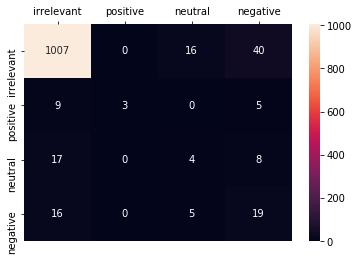

In [322]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_true, pred_cas_bpef_ir, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_true, pred_cas_bpef_ir, average='micro')))
cm = confusion_matrix(valid_true, pred_cas_bpef_ir, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

### Classification with test data

In [323]:
# valid_y_4l validation dataset
collections.Counter(test_y_4l)

Counter({0: 1328, 3: 49, 2: 37, 1: 22})

In [324]:
# use validation set of 4 labels classifier
test_idx = list(test_y_4l.index)
test_dataset_X_cas = original_dataset.loc[test_idx]
test_dataset_X_cas

,TESTO,(Testo Citato),Assistenza/Concessionari
3750,Mi sembra un discorso che in ogni decennio ( d...,,irrilevante
4116,Io compaio in 6 foto quasi quasi.. poi vedro' ...,,irrilevante
6406,Ho raddrizzato io: dai però una studiata qui p...,'Mi è venuta girata la foto !',irrilevante
2126,sperem....l'importante e che il cambio sia abb...,,irrilevante
5736,Si il mio era solo per chiarire che i problemi...,"""si ma con i 10-12'000 km/anno che dichiara di...",irrilevante
2395,oggi mi \xe8 arrivata la vaschetta ! ora devo ...,,irrilevante
3695,mi hai fatto ricordare i bei tempi quando c'er...,pilota54 ha scritto: In pista sarebbe certamen...,irrilevante
131,Certo non si capisce più niente... Tanto casin...,,negativo
6204,eccoci vicini alla presentazione:http://www.au...,,irrilevante
5861,Devo essere onesto e devo ammettere che verso ...,,irrilevante


irrelevant / relevant

In [325]:
# irrelevant / relevant
test_dataset_X_cas_svm = test_dataset_X_cas.copy(deep=True)
pp = Preprocessor()
# TESTO
for i in range(test_dataset_X_cas_svm.shape[0]):
    test_dataset_X_cas_svm['TESTO'].iloc[i] = pp.preprocessText(test_dataset_X_cas_svm['TESTO'].iloc[i], method='word', use_stemmer=True, ner=True)
# (Testo Citato)
for i in range(test_dataset_X_cas_svm.shape[0]):
    test_dataset_X_cas_svm['(Testo Citato)'].iloc[i] = pp.preprocessText(test_dataset_X_cas_svm['(Testo Citato)'].iloc[i], method='word', use_stemmer=True, ner=True)    

In [326]:
test_concat_svm = []
for i in range(len(test_dataset_X_cas_svm)):
    test_concat_svm.append(combine_text_quote(test_dataset_X_cas_svm['TESTO'].iloc[i], test_dataset_X_cas_svm['(Testo Citato)'].iloc[i], divide_quote=False))

In [327]:
# predict irrelevant/relevant
test_X_cas_svm = vec_logreg.transform(test_concat_svm)
test_X_cas_svm_fs = test_X_cas_svm[:, list(selected_features_logreg)]

In [328]:
test_pred_cas_svm_ir = clf_logreg_fs.best_estimator_.predict(test_X_cas_svm_fs)

sentiment with SVM

In [329]:
for i in range(len(test_pred_cas_svm_ir)):
    if test_pred_cas_svm_ir[i] == 1:
        v = vec_snt.transform([test_concat_svm[i]])
        v_fs = v[0,list(selected_features_snt)]
        p = clf_fs_snt.best_estimator_.predict(v_fs)
        test_pred_cas_svm_ir[i] = p

In [330]:
collections.Counter(test_pred_cas_svm_ir)

Counter({0: 1318, 3: 86, 1: 8, 2: 24})

In [331]:
test_true = test_dataset_X_cas[column].replace('irrilevante', 0).replace('positivo', 1).replace('neutro', 2).replace('negativo', 3).replace('molto positivo', 1).replace('molto negativo', 3).tolist()

F1 macro score on validation data: 0.3929023704199348
F1 micro score on validation data: 0.9045961002785515


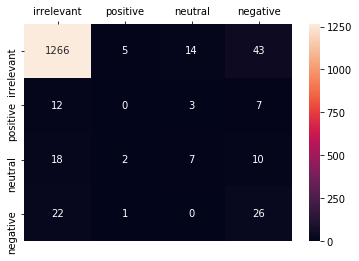

In [332]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 macro score on validation data: ' + str(f1_score(test_true, test_pred_cas_svm_ir, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(test_true, test_pred_cas_svm_ir, average='micro')))
cm = confusion_matrix(test_true, test_pred_cas_svm_ir, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

sentiment with BPEF

In [333]:
test_dataset_X_cas_bpef = test_dataset_X_cas.copy(deep=True)
test_pred_cas_bpef_ir = test_pred_cas_svm_ir

In [334]:
for i in range(len(test_pred_cas_bpef_ir)):
    if test_pred_cas_bpef_ir[i] == 1:
        testo = test_dataset_X_cas_bpef.iloc[i]['TESTO']
        quote = test_dataset_X_cas_bpef.iloc[i]['(Testo Citato)']
        p = bpef.predict(pd.Series(testo), pd.Series(quote))
        test_pred_cas_bpef_ir[i] = p[0]

######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, '

F1 macro score on validation data: 0.4059509891105303
F1 micro score on validation data: 0.9066852367688022


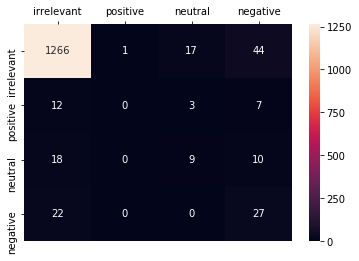

In [335]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 macro score on validation data: ' + str(f1_score(test_true, test_pred_cas_bpef_ir, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(test_true, test_pred_cas_bpef_ir, average='micro')))
cm = confusion_matrix(test_true, test_pred_cas_bpef_ir, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

## Unlabeled Data

In [336]:
new_unlabeled_dataset = pd.read_csv('unlabeled/unlabeled_dataset_engine.csv')
del new_unlabeled_dataset['Unnamed: 0']
new_unlabeled_dataset = new_unlabeled_dataset.replace(np.nan, '', regex=True)
new_unlabeled_dataset

,Forum,Thread_Title,URL,Timestamp,Username,Subscription_Date,Num_Messages,Quote,Text,Engine,Brand,Exterior
0,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,19-07-2017 01:26:00,pilota54,03-04-2009 02:01:04,27259,,Stanno circolando sul web le prime immagini di...,neutro,neutro,irrilevante
1,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,10-04-2018 18:06:00,pilota54,03-04-2009 02:01:04,27259,,Dovrebbe essere presentata entro l'anno la Por...,neutro,irrilevante,irrilevante
2,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,11-04-2018 20:16:00,Mastertanto,01-04-2009 03:16:07,3582,'Dovrebbe essere presentata entro l\'anno la P...,"A me va benissimo. E mantiene il vecchio, caro...",neutro,irrilevante,irrilevante
3,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,11-04-2018 20:27:00,Mastertanto,01-04-2009 03:16:07,3582,' ma con variazioni più significative rispetto...,Per fortuna. Perché quello sarebbe un po' sven...,positivo,irrilevante,irrilevante
4,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,12-04-2018 00:50:00,pilota54,03-04-2009 02:01:04,27259,,"Si, sulla 911 di serie il motore centrale non ...",neutro,irrilevante,irrilevante
5,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,19-04-2018 14:03:00,pilota54,03-04-2009 02:01:04,27259,,"Proseguono i test al ""Ring"" della 992, in part...",irrilevante,irrilevante,irrilevante
6,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,25-06-2018 18:09:00,pilota54,03-04-2009 02:01:04,27259,,"Ancora test al ""Ring"" per l'attesa Porsche 911...",irrilevante,irrilevante,irrilevante
7,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,7-07-2018 11:43:00,Mastertanto,01-04-2009 03:16:07,3582,"'Ancora test al ""Ring"" per l\'attesa Porsche 9...",Io sono convinto che in ogni caso difficilment...,irrilevante,positivo,negativo
8,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,7-07-2018 11:58:00,pilota54,03-04-2009 02:01:04,27259,,Ame della 911 (le versioni aspirate) quello ch...,irrilevante,irrilevante,irrilevante
9,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,7-07-2018 15:30:00,LA MAGA,18-05-2018 23:35:16,1075,,chissà se ce la faranno a mettere il navigator...,irrilevante,irrilevante,irrilevante


Preprocessing

In [337]:
unlabeled_dataset = new_unlabeled_dataset.copy(deep=True)
new_unlabeled_dataset

,Forum,Thread_Title,URL,Timestamp,Username,Subscription_Date,Num_Messages,Quote,Text,Engine,Brand,Exterior
0,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,19-07-2017 01:26:00,pilota54,03-04-2009 02:01:04,27259,,Stanno circolando sul web le prime immagini di...,neutro,neutro,irrilevante
1,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,10-04-2018 18:06:00,pilota54,03-04-2009 02:01:04,27259,,Dovrebbe essere presentata entro l'anno la Por...,neutro,irrilevante,irrilevante
2,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,11-04-2018 20:16:00,Mastertanto,01-04-2009 03:16:07,3582,'Dovrebbe essere presentata entro l\'anno la P...,"A me va benissimo. E mantiene il vecchio, caro...",neutro,irrilevante,irrilevante
3,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,11-04-2018 20:27:00,Mastertanto,01-04-2009 03:16:07,3582,' ma con variazioni più significative rispetto...,Per fortuna. Perché quello sarebbe un po' sven...,positivo,irrilevante,irrilevante
4,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,12-04-2018 00:50:00,pilota54,03-04-2009 02:01:04,27259,,"Si, sulla 911 di serie il motore centrale non ...",neutro,irrilevante,irrilevante
5,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,19-04-2018 14:03:00,pilota54,03-04-2009 02:01:04,27259,,"Proseguono i test al ""Ring"" della 992, in part...",irrilevante,irrilevante,irrilevante
6,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,25-06-2018 18:09:00,pilota54,03-04-2009 02:01:04,27259,,"Ancora test al ""Ring"" per l'attesa Porsche 911...",irrilevante,irrilevante,irrilevante
7,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,7-07-2018 11:43:00,Mastertanto,01-04-2009 03:16:07,3582,"'Ancora test al ""Ring"" per l\'attesa Porsche 9...",Io sono convinto che in ogni caso difficilment...,irrilevante,positivo,negativo
8,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,7-07-2018 11:58:00,pilota54,03-04-2009 02:01:04,27259,,Ame della 911 (le versioni aspirate) quello ch...,irrilevante,irrilevante,irrilevante
9,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,7-07-2018 15:30:00,LA MAGA,18-05-2018 23:35:16,1075,,chissà se ce la faranno a mettere il navigator...,irrilevante,irrilevante,irrilevante


In [338]:
irr_rel_concat = []
pp = Preprocessor()
for i in range(len(unlabeled_dataset)):
    irr_rel_concat.append(combine_text_quote(pp.preprocessText(unlabeled_dataset['Text'].iloc[i], use_stemmer=True, ner=True), pp.preprocessText(unlabeled_dataset['Quote'].iloc[i], use_stemmer=True, ner=True), divide_quote=False))

Vectorize for irrelevant / relevant

In [339]:
irr_rel_vectorized = vec.transform(irr_rel_concat)[:, list(selected_features_logreg)]
irr_rel_vectorized.shape

(2357, 615)

Predict irerelevant/relevant

In [340]:
unlabeled_pred_ir = clf_logreg_fs.best_estimator_.predict(irr_rel_vectorized)

In [341]:
collections.Counter(unlabeled_pred_ir)

Counter({0: 2266, 1: 91})

Predict Support Sentiment

In [342]:
for i in range(len(unlabeled_pred_ir)):
    if unlabeled_pred_ir[i] == 1:
        testo = unlabeled_dataset.iloc[i]['Text']
        quote = unlabeled_dataset.iloc[i]['Quote']
        p = bpef.predict(pd.Series(testo), pd.Series(quote))
        print(p)
        unlabeled_pred_ir[i] = p[0]

######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, '

######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
[3]
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', Fals

######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
[3]
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', Fals

######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
[2]
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', Fals

######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
[3]
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', Fals

######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
[3]
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', Fals

######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
[3]
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', Fals

######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
[2]
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', Fals

######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
[2]
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', Fals

######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
[2]
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', Fals

[3]
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', Tru

In [343]:
collections.Counter(unlabeled_pred_ir)

Counter({0: 2266, 2: 34, 3: 53, 1: 4})

In [344]:
unlabeled_labels = []
for i in range(len(unlabeled_pred_ir)):
    if unlabeled_pred_ir[i] == 0:
        unlabeled_labels.append('irrilevante')
    elif unlabeled_pred_ir[i] == 1:
        unlabeled_labels.append('positivo')
    elif unlabeled_pred_ir[i] == 2:
        unlabeled_labels.append('neutro')
    elif unlabeled_pred_ir[i] == 3:
        unlabeled_labels.append('negativo')

In [345]:
new_unlabeled_dataset['Support'] = unlabeled_labels

In [346]:
new_unlabeled_dataset

,Forum,Thread_Title,URL,Timestamp,Username,Subscription_Date,Num_Messages,Quote,Text,Engine,Brand,Exterior,Support
0,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,19-07-2017 01:26:00,pilota54,03-04-2009 02:01:04,27259,,Stanno circolando sul web le prime immagini di...,neutro,neutro,irrilevante,irrilevante
1,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,10-04-2018 18:06:00,pilota54,03-04-2009 02:01:04,27259,,Dovrebbe essere presentata entro l'anno la Por...,neutro,irrilevante,irrilevante,irrilevante
2,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,11-04-2018 20:16:00,Mastertanto,01-04-2009 03:16:07,3582,'Dovrebbe essere presentata entro l\'anno la P...,"A me va benissimo. E mantiene il vecchio, caro...",neutro,irrilevante,irrilevante,irrilevante
3,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,11-04-2018 20:27:00,Mastertanto,01-04-2009 03:16:07,3582,' ma con variazioni più significative rispetto...,Per fortuna. Perché quello sarebbe un po' sven...,positivo,irrilevante,irrilevante,irrilevante
4,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,12-04-2018 00:50:00,pilota54,03-04-2009 02:01:04,27259,,"Si, sulla 911 di serie il motore centrale non ...",neutro,irrilevante,irrilevante,irrilevante
5,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,19-04-2018 14:03:00,pilota54,03-04-2009 02:01:04,27259,,"Proseguono i test al ""Ring"" della 992, in part...",irrilevante,irrilevante,irrilevante,irrilevante
6,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,25-06-2018 18:09:00,pilota54,03-04-2009 02:01:04,27259,,"Ancora test al ""Ring"" per l'attesa Porsche 911...",irrilevante,irrilevante,irrilevante,irrilevante
7,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,7-07-2018 11:43:00,Mastertanto,01-04-2009 03:16:07,3582,"'Ancora test al ""Ring"" per l\'attesa Porsche 9...",Io sono convinto che in ogni caso difficilment...,irrilevante,positivo,negativo,irrilevante
8,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,7-07-2018 11:58:00,pilota54,03-04-2009 02:01:04,27259,,Ame della 911 (le versioni aspirate) quello ch...,irrilevante,irrilevante,irrilevante,irrilevante
9,Quattroruote,Porsche 911/992,https://forum.quattroruote.it/threads/porsche-...,7-07-2018 15:30:00,LA MAGA,18-05-2018 23:35:16,1075,,chissà se ce la faranno a mettere il navigator...,irrilevante,irrilevante,irrilevante,neutro


In [347]:
new_unlabeled_dataset.to_csv('unlabeled/unlabeled_dataset_engine.csv')

In [168]:
import dill
dill.dump_session('notebook_env.db')

In [3]:
import dill
dill.load_session('notebook_env.db')

KeyError: 'ClassType'